# Binary Classification of Machine Failures

## Index <a id="index"></a>

- [Libraries](#libraries)
- [Import Data](#import_data)
- [Data Cleaning](#data_cleaning)
- [Exploratory Data Analysis](#eda)
- [Preprocessing](#preprocessing)
- [PCA Analysis](#pca)
- [Model](#model)
- [Save Predictions](#savepreds)

## Libraries <a id="libraries"></a>

[Return to Index](#index)

In [1]:
import os

In [2]:
if 'source' not in os.listdir():
    os.chdir('..')

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from source.model_toolkit import models as mods
from scikeras.wrappers import KerasClassifier

In [4]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.utils.class_weight import compute_class_weight

In [5]:
import lightgbm as lgb

In [6]:
import tensorflow as tf

## Import Data <a id="import_data"></a>

[Return to Index](#index)

In [7]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

In [8]:
train_data

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136424,136424,M22284,M,300.1,311.4,1530,37.5,210,0,0,0,0,0,0
136425,136425,H38017,H,297.5,308.5,1447,49.1,2,0,0,0,0,0,0
136426,136426,L54690,L,300.5,311.8,1524,38.5,214,0,0,0,0,0,0
136427,136427,L53876,L,301.7,310.9,1447,46.3,42,0,0,0,0,0,0


## Data Cleaning <a id="data_cleaning"></a>

[Return to Index](#index)

The training data contains **136429** rows.

In [9]:
len(train_data)

136429

In [10]:
train_data.dtypes

id                           int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object

The training data contains **no nulls** on any columnn

In [11]:
pd.isnull(train_data).sum()

id                         0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

**Product ID** column contains **9976** unique values. Each contains less than **1%** rows. We should not use this variable.

In [12]:
train_data['Product ID'].value_counts(normalize = True)

Product ID
L53257    0.001019
L49056    0.000960
L53271    0.000960
L54275    0.000880
L48892    0.000880
            ...   
M24614    0.000007
H39399    0.000007
M15853    0.000007
H32637    0.000007
L48036    0.000007
Name: proportion, Length: 9976, dtype: float64

**Type** column contains **3** unique values, 'L', 'M' and 'H'.

In [13]:
train_data['Type'].value_counts(normalize = True)

Type
L    0.698928
M    0.235668
H    0.065404
Name: proportion, dtype: float64

The dataset is very **unbalanced**. Class balancing must be done.

In [14]:
train_data['Machine failure'].value_counts(normalize = True)

Machine failure
0    0.984256
1    0.015744
Name: proportion, dtype: float64

## Exploratory Data Analysis <a id="eda"></a>

[Return to Index](#index)

Define numerical and categorical columns

In [15]:
train_data.columns

Index(['id', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')

In [16]:
exclude_cols = ['id', 'Product ID', 'Machine failure']

categorical_cols = ['Type', 'TWF', 'HDF' ,'PWF', 'OSF', 'RNF']

numerical_cols = [col for col in train_data.columns if col not in exclude_cols + categorical_cols]

### Numerical Columns

In [17]:
def boxplot_bytarget(df, cols, target_var, **kwargs):
    ylabels = df[target_var].unique()
    
    for i in range(len(cols)):
        fig, ax = plt.subplots()
        ax.boxplot([df[df[target_var] == ylabel][cols[i]] for ylabel in ylabels], **kwargs)
        
        ax.set_ylabel(cols[i])
        ax.set_xlabel(target_var)
        
        ax.set_xticklabels(ylabels)
        
        ax.set_title(f'Boxplot of {cols[i]} by {target_var}') 
        plt.show()

In [18]:
def hist_bytarget(df, cols, target_var, **kwargs):
    ylabels = df[target_var].unique()
    
    for i in range(len(cols)):
        fig, ax = plt.subplots()
        for ylabel in ylabels:
            ax.hist(df[df[target_var] == ylabel][cols[i]], label = ylabel, **kwargs)
        
        ax.set_xlabel(cols[i])
        ax.set_ylabel('Relative Frequency')
        
        ax.legend()
        ax.set_title(f'Histogram of {cols[i]} by {target_var}')
        
        plt.show()

In [19]:
def plot_corrmatrix(df, cols):
    data = df[cols].corr()
    
    fig, ax = plt.subplots()
    
    cax = ax.matshow(data)
    
    ax.set_xticks(range(len(numerical_cols)), labels = numerical_cols, rotation = 45)
    ax.set_yticks(range(len(numerical_cols)), labels = numerical_cols)

    for (i, j), value in np.ndenumerate(data):
        ax.text(i, j, f'{round(value, 2)}')
    
    ax.set_title('Correlation Matrix')
    fig.colorbar(cax)
    
    plt.show()

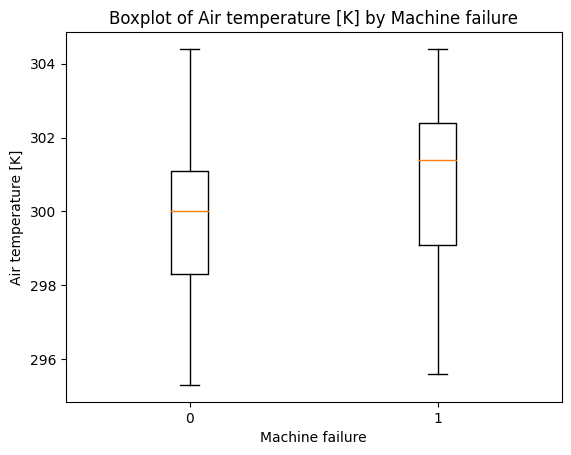

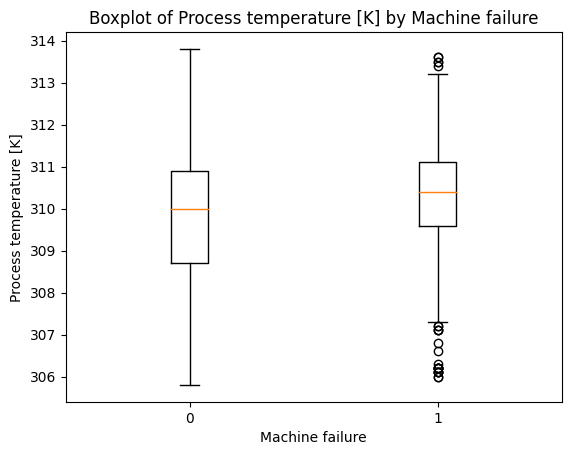

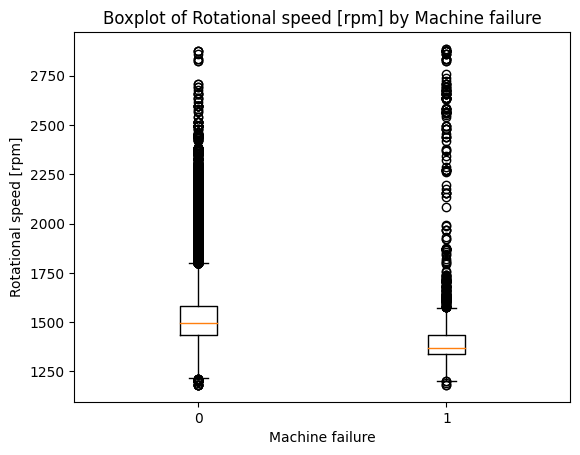

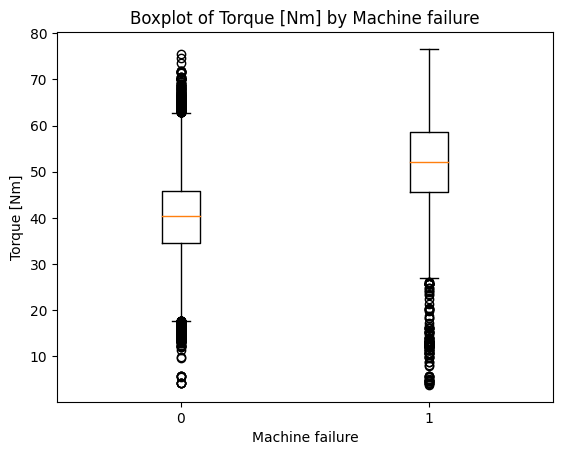

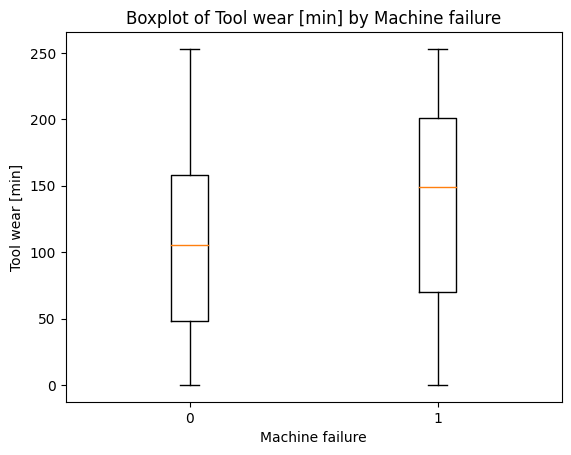

In [20]:
boxplot_bytarget(train_data, numerical_cols, 'Machine failure')

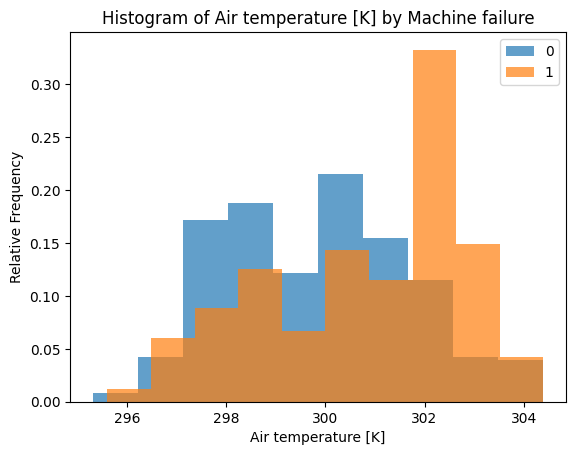

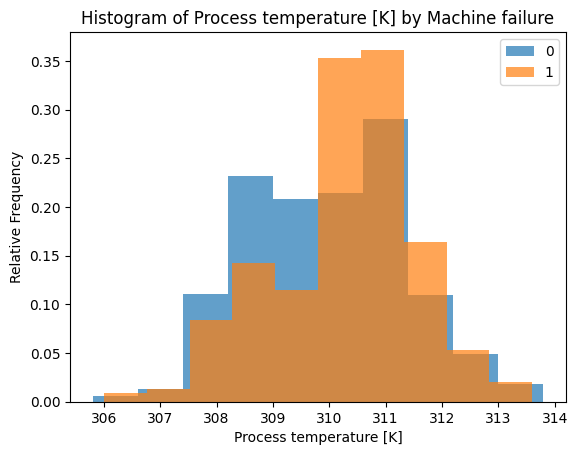

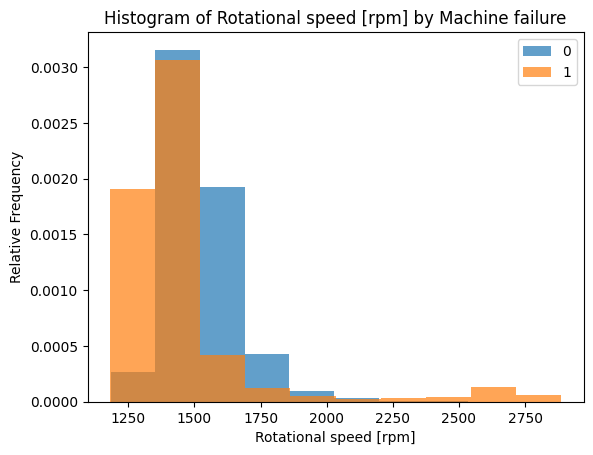

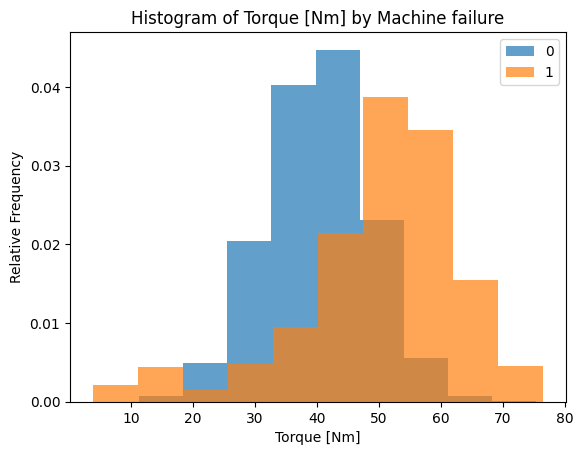

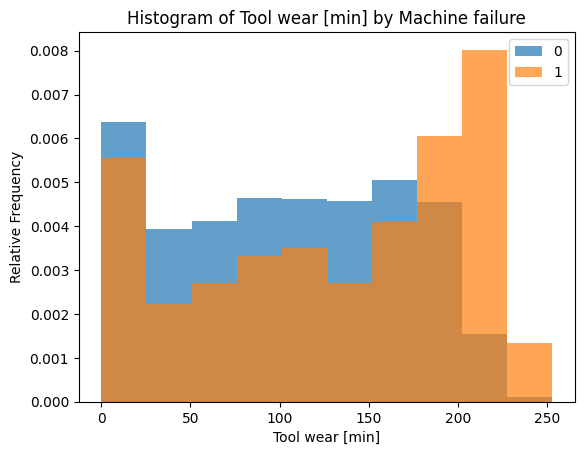

In [21]:
hist_bytarget(train_data, numerical_cols, 'Machine failure', density = True, alpha = 0.7)

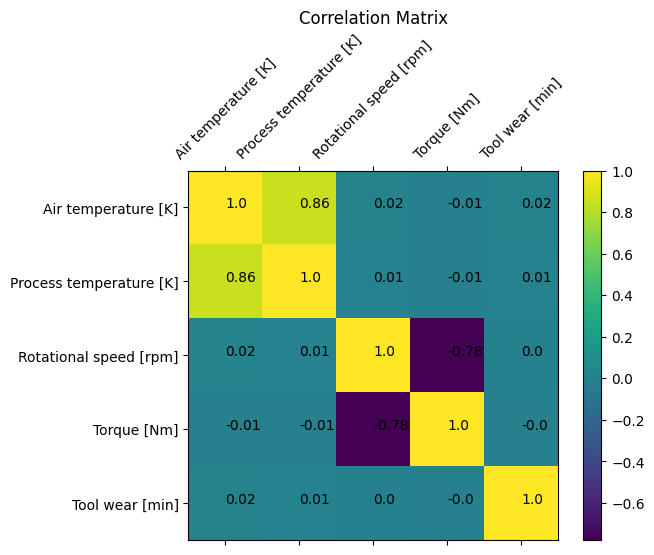

In [22]:
plot_corrmatrix(train_data, numerical_cols)

### Categorical Columns

In [23]:
def bar_bytarget(df, cols, target_var):
    ylabels = df[target_var].unique()
    
    for col in cols:
        xlabels = df[col].unique()
        data = df.groupby(col)[target_var].agg('mean')
        
        fig, ax = plt.subplots()
        
        bax = ax.bar(xlabels, data)
        
        ax.set_xticks(xlabels)
        
        ax.set_xlabel(col)
        ax.set_ylabel(f'Average {target_var}')
        
        ax.set_title(f'Average {target_var} by {col}')
        
        plt.show()

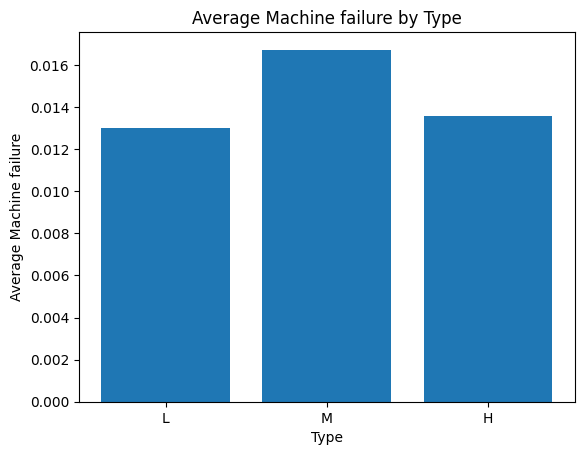

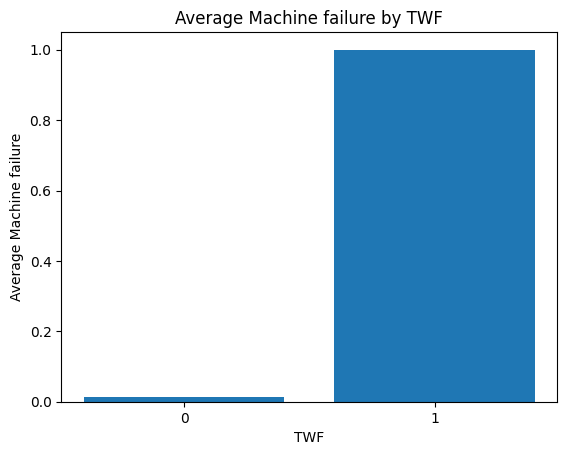

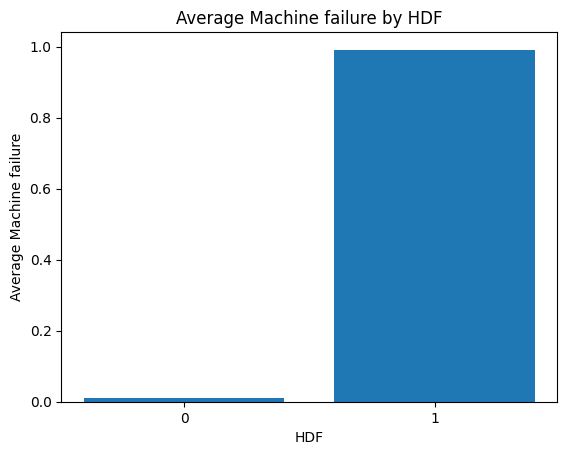

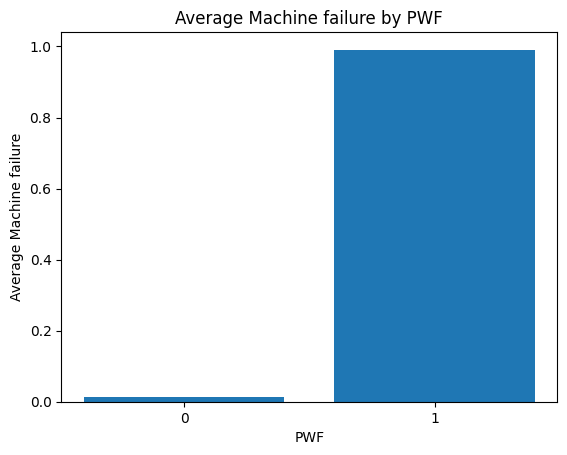

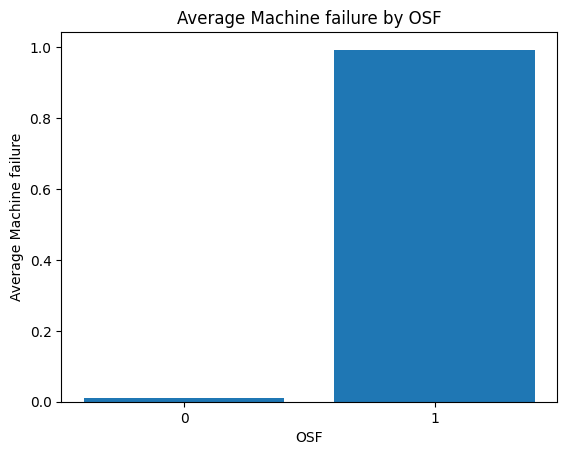

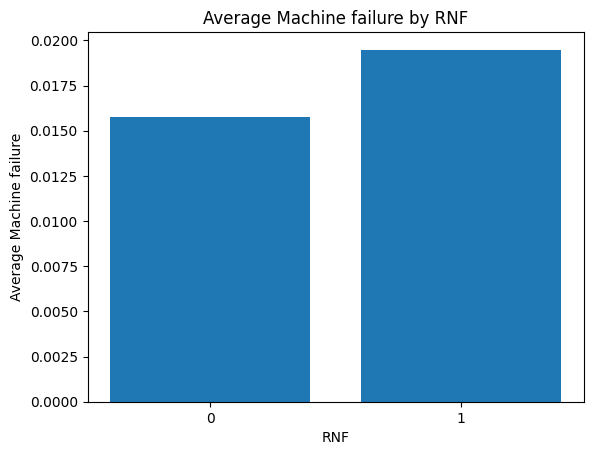

In [24]:
bar_bytarget(train_data, categorical_cols, 'Machine failure')

## Preprocessing <a id="preprocessing"></a>

[Return to Index](#index)

Selection of final columns

In [25]:
categorical_features = categorical_cols
numerical_features = numerical_cols

### Train-Test Split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    train_data[numerical_features + categorical_features],
    train_data['Machine failure'],
    train_size = 0.7, 
    random_state = 23,
    stratify = train_data['Machine failure']
)

## PCA Analysis <a id="pca"></a>

[Return to Index](#index)

In [27]:
pca = Pipeline(
    [
        (
            'column_transformer',
            ColumnTransformer(
                [
                    (
                        'numeric',
                        Pipeline(
                            [
                                ('impute', SimpleImputer(strategy = 'mean')),
                                ('scale', StandardScaler())
                            ]
                        ),
                        numerical_features
                    ),
                    (
                        'categoric',
                        Pipeline(
                            [
                                ('impute', SimpleImputer(strategy = 'most_frequent')),
                                ('encode', OneHotEncoder(handle_unknown = 'ignore', sparse_output = False, drop = 'if_binary'))
                            ]
                        ),
                        categorical_features
                    )
                ]
            )
        ),
        ('pca', PCA())
    ]
)
pca.fit(X_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['Air temperature [K]',
                                                   'Process temperature [K]',
                                                   'Rotational speed [rpm]',
                                                   'Torque [Nm]',
                                                   'Tool wear [min]']),
                                                 ('categoric',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Type', 'TWF', 'HDF', 'PWF',
                                                   'OSF', 'RNF'])])),
                ('pca', PCA())])

In [28]:
def plot_PCA(df, y, target_var):
    ylabels = y.unique()
    
    fig, ax = plt.subplots()
    
    for ylabel in ylabels:
        ax.scatter(df[y == ylabel, 0], df[y == ylabel, 1], label = ylabel)
    
    ax.set_xlabel('First Principal Component')
    ax.set_ylabel('Second Principal Component')
    
    ax.legend()
    ax.set_title(f'First 2 Principal components by {target_var}')
    
    plt.show()    

We'll plot the first two Principal Components

There doesn't to be a distinct boundary between the classes but the values of each respective class seem to be mostly grouped together. KNN could work well to predict class

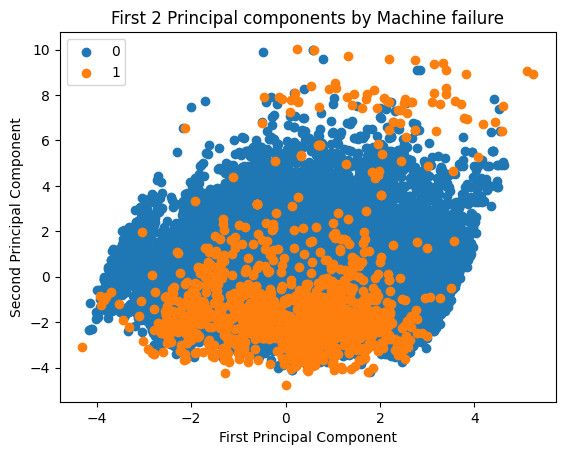

In [29]:
plot_PCA(pca.transform(X_train), y_train, 'Machine failure')

As we plot the Explained variance of the PCA, we can see that the first four components explain more than 90% of the variance.

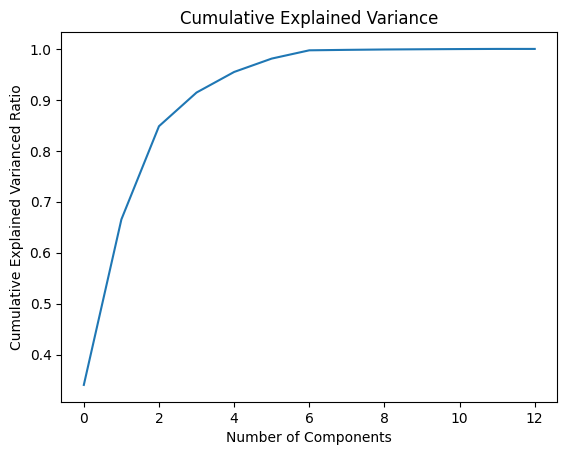

In [30]:
fig, ax = plt.subplots()

ax.plot(pca.steps[1][1].explained_variance_ratio_.cumsum())

ax.set_xlabel('Number of Components')
ax.set_ylabel('Cumulative Explained Varianced Ratio')

ax.set_title('Cumulative Explained Variance')

plt.show()

## Model <a id="model"></a>

- [K Nearest Neighbors](#knn)
- [LightGBM](#lightgbm)
- [MLP](#mlp)
- [Final Model](#finalmodel)
- [Evaluate Model](#evaluate)

[Return to Index](#index)

We create a cv instance to train our models

In [31]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 23)

### K Nearest Neighbors <a id="knn"></a>

[Back to Model](#model)

In [32]:
knn_grid = {
    'knn__n_neighbors': [3, 5, 7],
    'knn__weights': ['uniform', 'distance']
}

In [33]:
knn_estimator = Pipeline(
    [
        (
            'column_transformer',
            ColumnTransformer(
                [
                    (
                        'numeric',
                        Pipeline(
                            [
                                ('impute', SimpleImputer(strategy = 'mean')),
                                ('scale', StandardScaler())
                            ]
                        ),
                        numerical_features
                    ),
                    (
                        'categoric',
                        Pipeline(
                            [
                                ('impute', SimpleImputer(strategy = 'most_frequent')),
                                ('encode', OneHotEncoder(handle_unknown = 'ignore', sparse_output = False, drop = 'if_binary'))
                            ]
                        ),
                        categorical_features
                    )
                ]
            )
        ),
        ('knn', KNeighborsClassifier())
    ]
)

In [34]:
knn = GridSearchCV(
    estimator = knn_estimator,
    param_grid = knn_grid,
    scoring = 'average_precision',
    cv = cv,
    refit = True
)

In [35]:
knn.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=23, shuffle=True),
             estimator=Pipeline(steps=[('column_transformer',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer()),
                                                                                         ('scale',
                                                                                          StandardScaler())]),
                                                                         ['Air '
                                                                          'temperature '
                                                                          '[K]',
                                                                          'Process '
                                                                          'temperature '
                                                                          '[K]',
                                                                          'Rotational '
                                                                          'speed '
                                                                          '[rpm]',
                                                                          'Torque '
                                                                          '[Nm]',
                                                                          'Tool '
                                                                          'wear '
                                                                          '[min]']),
                                                                        ('categoric',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encode',
                                                                                          OneHotEncoder(drop='if_binary',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['Type',
                                                                          'TWF',
                                                                          'HDF',
                                                                          'PWF',
                                                                          'OSF',
                                                                          'RNF'])])),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [3, 5, 7],
                         'knn__weights': ['uniform', 'distance']},
             scoring='average_precision')

In [36]:
knn_best_params = {key.split('__')[-1]: value for key, value in knn.best_params_.items()}
print(knn_best_params)

{'n_neighbors': 7, 'weights': 'distance'}


In [37]:
best_knn = knn.best_estimator_

ROC AUC

In [38]:
roc_auc_score(y_test, best_knn.predict_proba(X_test)[:, 1])

0.8664400270741773

PR AUC

In [39]:
average_precision_score(y_test, best_knn.predict_proba(X_test)[:, 1])

0.7121686539816201

### LightGBM <a id="lightgbm"></a>

[Back to Model](#model)

In [40]:
lgbm_grid = [
    {
        'lgbm__max_depth': [-1],
        'lgbm__num_leaves': [50, 75, 100],
        'lgbm__subsample': [0.5, 0.7, 1],
        'lgbm__colsample_bytree': [0.6, 0.8, 1],
        'lgbm__max_bin': [150, 200, 255],
        'lgbm__learning_rate': [0.1],
        'lgbm__n_estimators': [50, 70, 100]
    },
    {
        'lgbm__max_depth': [3],
        'lgbm__num_leaves': [10, 20, 30],
        'lgbm__subsample': [0.5, 0.7, 1],
        'lgbm__colsample_bytree': [0.6, 0.8, 1],
        'lgbm__max_bin': [150, 200, 255],
        'lgbm__learning_rate': [0.1],
        'lgbm__n_estimators': [50, 70, 100]
    },
    {
        'lgbm__max_depth': [5],
        'lgbm__num_leaves': [20, 30, 40],
        'lgbm__subsample': [0.5, 0.7, 1],
        'lgbm__colsample_bytree': [0.6, 0.8, 1],
        'lgbm__max_bin': [150, 200, 255],
        'lgbm__learning_rate': [0.1],
        'lgbm__n_estimators': [50, 70, 100]
    },
    {
        'lgbm__max_depth': [7],
        'lgbm__num_leaves': [30, 40, 50],
        'lgbm__subsample': [0.5, 0.7, 1],
        'lgbm__colsample_bytree': [0.6, 0.8, 1],
        'lgbm__max_bin': [150, 200, 255],
        'lgbm__learning_rate': [0.1],
        'lgbm__n_estimators': [50, 70, 100]
    },
    {
        'lgbm__max_depth': [-1],
        'lgbm__num_leaves': [50, 75, 100],
        'lgbm__subsample': [0.5, 0.7, 1],
        'lgbm__colsample_bytree': [0.6, 0.8, 1],
        'lgbm__max_bin': [150, 200, 255],
        'lgbm__learning_rate': [0.05],
        'lgbm__n_estimators': [70, 100, 120]
    },
    {
        'lgbm__max_depth': [3],
        'lgbm__num_leaves': [10, 20, 30],
        'lgbm__subsample': [0.5, 0.7, 1],
        'lgbm__colsample_bytree': [0.6, 0.8, 1],
        'lgbm__max_bin': [150, 200, 255],
        'lgbm__learning_rate': [0.05],
        'lgbm__n_estimators': [70, 100, 120]
    },
    {
        'lgbm__max_depth': [5],
        'lgbm__num_leaves': [20, 30, 40],
        'lgbm__subsample': [0.5, 0.7, 1],
        'lgbm__colsample_bytree': [0.6, 0.8, 1],
        'lgbm__max_bin': [150, 200, 255],
        'lgbm__learning_rate': [0.05],
        'lgbm__n_estimators': [70, 100, 120]
    },
    {
        'lgbm__max_depth': [7],
        'lgbm__num_leaves': [30, 40, 50],
        'lgbm__subsample': [0.5, 0.7, 1],
        'lgbm__colsample_bytree': [0.6, 0.8, 1],
        'lgbm__max_bin': [150, 200, 255],
        'lgbm__learning_rate': [0.05],
        'lgbm__n_estimators': [70, 100, 120]
    },
    {
        'lgbm__max_depth': [-1],
        'lgbm__num_leaves': [50, 75, 100],
        'lgbm__subsample': [0.5, 0.7, 1],
        'lgbm__colsample_bytree': [0.6, 0.8, 1],
        'lgbm__max_bin': [150, 200, 255],
        'lgbm__learning_rate': [0.1],
        'lgbm__n_estimators': [50, 70, 100]
    },
    {
        'lgbm__max_depth': [3],
        'lgbm__num_leaves': [10, 20, 30],
        'lgbm__subsample': [0.5, 0.7, 1],
        'lgbm__colsample_bytree': [0.6, 0.8, 1],
        'lgbm__max_bin': [150, 200, 255],
        'lgbm__learning_rate': [0.01],
        'lgbm__n_estimators': [100, 120, 150]
    },
    {
        'lgbm__max_depth': [5],
        'lgbm__num_leaves': [20, 30, 40],
        'lgbm__subsample': [0.5, 0.7, 1],
        'lgbm__colsample_bytree': [0.6, 0.8, 1],
        'lgbm__max_bin': [150, 200, 255],
        'lgbm__learning_rate': [0.01],
        'lgbm__n_estimators': [100, 120, 150]
    },
    {
        'lgbm__max_depth': [7],
        'lgbm__num_leaves': [30, 40, 50],
        'lgbm__subsample': [0.5, 0.7, 1],
        'lgbm__colsample_bytree': [0.6, 0.8, 1],
        'lgbm__max_bin': [150, 200, 255],
        'lgbm__learning_rate': [0.01],
        'lgbm__n_estimators': [100, 120, 150]
    },
]

In [41]:
lgbm_estimator = Pipeline(
    [
        (
            'column_transformer',
            ColumnTransformer(
                [
                    (
                        'numeric',
                        Pipeline(
                            [
                                ('impute', SimpleImputer(strategy = 'mean')),
                                ('scale', StandardScaler())
                            ]
                        ),
                        numerical_features
                    ),
                    (
                        'categoric',
                        Pipeline(
                            [
                                ('impute', SimpleImputer(strategy = 'most_frequent')),
                                (
                                    'encode', OrdinalEncoder(
                                        handle_unknown = 'use_encoded_value', 
                                        unknown_value = -1
                                    )
                                )
                            ]
                        ),
                        categorical_features
                    )
                ]
            )
        ),
        ('lgbm', lgb.LGBMClassifier(random_state = 23, is_unbalance = True))
    ]
)

In [42]:
lgbm = RandomizedSearchCV(
    lgbm_estimator,
    n_iter = 50,
    param_distributions = lgbm_grid,
    scoring = 'average_precision',
    cv = cv,
    random_state = 23,
    refit = True
)

In [43]:
lgbm.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=23, shuffle=True),
                   estimator=Pipeline(steps=[('column_transformer',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               Pipeline(steps=[('impute',
                                                                                                SimpleImputer()),
                                                                                               ('scale',
                                                                                                StandardScaler())]),
                                                                               ['Air '
                                                                                'temperature '
                                                                                '[K]',
                                                                                'Process '
                                                                                'temperature '
                                                                                '[K]',
                                                                                'Rotational '
                                                                                'speed '
                                                                                '[rpm]',
                                                                                'Torque '
                                                                                '[Nm]',
                                                                                'Tool '
                                                                                'wear '
                                                                                '...
                                         'lgbm__n_estimators': [100, 120, 150],
                                         'lgbm__num_leaves': [20, 30, 40],
                                         'lgbm__subsample': [0.5, 0.7, 1]},
                                        {'lgbm__colsample_bytree': [0.6, 0.8,
                                                                    1],
                                         'lgbm__learning_rate': [0.01],
                                         'lgbm__max_bin': [150, 200, 255],
                                         'lgbm__max_depth': [7],
                                         'lgbm__n_estimators': [100, 120, 150],
                                         'lgbm__num_leaves': [30, 40, 50],
                                         'lgbm__subsample': [0.5, 0.7, 1]}],
                   random_state=23, scoring='average_precision')

In [44]:
lgbm_best_params = {key.split('__')[-1]: value for key, value in lgbm.best_params_.items()}
print(lgbm_best_params)

{'subsample': 0.7, 'num_leaves': 50, 'n_estimators': 120, 'max_depth': -1, 'max_bin': 200, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


In [45]:
best_lgbm = lgbm.best_estimator_

ROC AUC

In [46]:
roc_auc_score(y_test, best_lgbm.predict_proba(X_test)[:, 1])

0.965807615306161

PR AUC

In [47]:
average_precision_score(y_test, best_lgbm.predict_proba(X_test)[:, 1])

0.8456691371370961

### MLP <a id="mlp"></a>

[Back to Model](#model)

In [147]:
def mlp_binary_classification_make_model(
    features_shape = 1,
    n_layers = 1,
    layer_size = 16,
    dropout = 0.0,
    output_bias = None,
    learning_rate = 0.01,
    metrics = [mods.METRICS]
):
    # Initialize Inputs
    inputs = tf.keras.Input(shape = (features_shape,))
    
    # Dense layers
    for i in range(n_layers):
        if i == 0:
            x = tf.keras.layers.Dense(layer_size, activation = 'relu')(inputs)
            x = tf.keras.layers.Dropout(dropout)(x)
            
        else:
            x = tf.keras.layers.Dense(layer_size, activation = 'relu')(x)
            x = tf.keras.layers.Dropout(dropout)(x)
            
    # Initialize bias
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        
    else:
        output_bias = 'zeros'  
    
    # Final layer
    if n_layers == 0:
        outputs = tf.keras.layers.Dense(1, activation = 'sigmoid', bias_initializer = output_bias)(inputs)
    
    else:
        outputs = tf.keras.layers.Dense(1, activation = 'sigmoid', bias_initializer = output_bias)(x)
        
    # Initialize model
    model = tf.keras.Model(inputs, outputs)
    
    # Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    
    # Compile model
    model.compile(
        loss = 'binary_crossentropy', 
        optimizer = optimizer, 
        metrics = metrics
    )
    
    return model

In [148]:
mlp_grid = {
#     'mlp__features_shape': [13], # check if more features are added
#     'mlp__target_shape': [len(y_train.unique())],
    'mlp__n_layers': [1, 3, 5, 7],
    'mlp__layer_size': [16, 32],
    'mlp__dropout': [0.2, 0.5],
    'mlp__learning_rate': [0.05, 0.01]
}

In [149]:
mlp_estimator = Pipeline(
    [
        (
            'column_transformer',
            ColumnTransformer(
                [
                    (
                        'numeric',
                        Pipeline(
                            [
                                ('inpute', SimpleImputer(strategy = 'mean')),
                                ('scale', MinMaxScaler())
                            ]
                        ),
                        numerical_features
                    ),
                    (
                        'categoric',
                        Pipeline(
                            [
                                ('impute', SimpleImputer(strategy = 'most_frequent')),
                                ('encode', OneHotEncoder(handle_unknown = 'ignore', sparse_output = False, drop = 'if_binary'))
                            ]
                        ),
                        categorical_features
                    )
                ]
            )
        ),
        (
            'mlp',
            KerasClassifier(
                build_fn = mlp_binary_classification_make_model, 
                features_shape = 13,
                n_layers = None,
                layer_size = None,
                dropout = None,
                learning_rate = None,
                verbose = True, 
                random_state = 23)
        )
    ]
)

In [150]:
mlp = RandomizedSearchCV(
    mlp_estimator,
    n_iter = 25,
    param_distributions = mlp_grid,
    random_state = 23,
    scoring = 'average_precision',
    cv = cv,
    refit = True
)

Class weight dict to balance classes

In [151]:
class_weights = {
    label: weight for label, weight in zip(
        np.unique(y_train), 
        compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train), y = y_train)
    )
}

In [152]:
mlp.fit(X_train, y_train, mlp__epochs = 5, mlp__batch_size = 32, mlp__class_weight = class_weights)

Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.7239 - tp: 4841.0000 - fp: 39704.0000 - tn: 1215700.0000 - fn: 15243.0000 - accuracy: 0.9569 - precision: 0.1087 - recall: 0.2410 - auc: 0.7674 - prc: 0.2145
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6983 - tp: 606.0000 - fp: 38370.0000 - tn: 36826.0000 - fn: 598.0000 - accuracy: 0.4899 - precision: 0.0155 - recall: 0.5033 - auc: 0.4932 - prc: 0.0155
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6976 - tp: 597.0000 - fp: 36731.0000 - tn: 38465.0000 - fn: 607.0000 - accuracy: 0.5113 - precision: 0.0160 - recall: 0.4958 - auc: 0.5010 - prc: 0.0158
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6984 - tp: 598.0000 - fp: 38410.0000 - tn: 36786.0000 - fn: 606.0000 - accuracy: 0.4893 - precision: 0.0153 - recall: 0.4967 - auc: 0.4896 - prc: 0.0151
Epoch 5/5
597/597 [==============================] - 0s 617us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.8778 - tp: 1279.0000 - fp: 78313.0000 - tn: 72080.0000 - fn: 1128.0000 - accuracy: 0.4801 - precision: 0.0161 - recall: 0.5314 - auc: 0.5049 - prc: 0.0159
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6986 - tp: 598.0000 - fp: 38234.0000 - tn: 36963.0000 - fn: 605.0000 - accuracy: 0.4916 - precision: 0.0154 - recall: 0.4971 - auc: 0.4900 - prc: 0.0154
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6970 - tp: 636.0000 - fp: 38580.0000 - tn: 36617.0000 - fn: 567.0000 - accuracy: 0.4876 - precision: 0.0162 - recall: 0.5287 - auc: 0.5095 - prc: 0.0160
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6972 - tp: 560.0000 - fp: 34416.0000 - tn: 40781.0000 - fn: 643.0000 - accuracy: 0.5411 - precision: 0.0160 - recall: 0.4655 - auc: 0.5000 - prc: 0.0161
Epoch 5/5
597/597 [==============================] - 0s 605us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.7272 - tp: 1173.0000 - fp: 75277.0000 - tn: 75117.0000 - fn: 1233.0000 - accuracy: 0.4993 - precision: 0.0153 - recall: 0.4875 - auc: 0.4945 - prc: 0.0157
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6986 - tp: 632.0000 - fp: 41288.0000 - tn: 33909.0000 - fn: 571.0000 - accuracy: 0.4521 - precision: 0.0151 - recall: 0.5254 - auc: 0.4888 - prc: 0.0150
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6978 - tp: 590.0000 - fp: 37218.0000 - tn: 37979.0000 - fn: 613.0000 - accuracy: 0.5048 - precision: 0.0156 - recall: 0.4904 - auc: 0.4975 - prc: 0.0154
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6977 - tp: 611.0000 - fp: 38365.0000 - tn: 36832.0000 - fn: 592.0000 - accuracy: 0.4901 - precision: 0.0157 - recall: 0.5079 - auc: 0.4968 - prc: 0.0155
Epoch 5/5
597/597 [==============================] - 0s 565us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.7650 - tp: 1142.0000 - fp: 68395.0000 - tn: 81999.0000 - fn: 1264.0000 - accuracy: 0.5441 - precision: 0.0164 - recall: 0.4746 - auc: 0.5095 - prc: 0.0287
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6973 - tp: 645.0000 - fp: 40171.0000 - tn: 35026.0000 - fn: 558.0000 - accuracy: 0.4669 - precision: 0.0158 - recall: 0.5362 - auc: 0.5040 - prc: 0.0158
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6979 - tp: 619.0000 - fp: 39429.0000 - tn: 35768.0000 - fn: 584.0000 - accuracy: 0.4763 - precision: 0.0155 - recall: 0.5145 - auc: 0.4926 - prc: 0.0153
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6963 - tp: 632.0000 - fp: 38904.0000 - tn: 36293.0000 - fn: 571.0000 - accuracy: 0.4833 - precision: 0.0160 - recall: 0.5254 - auc: 0.5087 - prc: 0.0161
Epoch 5/5
597/597 [==============================] - 0s 613us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.7435 - tp: 1234.0000 - fp: 77645.0000 - tn: 72749.0000 - fn: 1172.0000 - accuracy: 0.4842 - precision: 0.0156 - recall: 0.5129 - auc: 0.4954 - prc: 0.0155
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6981 - tp: 638.0000 - fp: 40146.0000 - tn: 35051.0000 - fn: 565.0000 - accuracy: 0.4671 - precision: 0.0156 - recall: 0.5303 - auc: 0.4910 - prc: 0.0151
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6984 - tp: 581.0000 - fp: 38315.0000 - tn: 36882.0000 - fn: 622.0000 - accuracy: 0.4904 - precision: 0.0149 - recall: 0.4830 - auc: 0.4817 - prc: 0.0147
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6973 - tp: 623.0000 - fp: 39041.0000 - tn: 36156.0000 - fn: 580.0000 - accuracy: 0.4814 - precision: 0.0157 - recall: 0.5179 - auc: 0.4993 - prc: 0.0155
Epoch 5/5
597/597 [==============================] - 0s 563us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.5391 - tp: 1390.0000 - fp: 58354.0000 - tn: 92039.0000 - fn: 1017.0000 - accuracy: 0.6114 - precision: 0.0233 - recall: 0.5775 - auc: 0.6690 - prc: 0.1861
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.4227 - tp: 825.0000 - fp: 7071.0000 - tn: 68125.0000 - fn: 379.0000 - accuracy: 0.9025 - precision: 0.1045 - recall: 0.6852 - auc: 0.8606 - prc: 0.5717
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.4317 - tp: 767.0000 - fp: 6401.0000 - tn: 68795.0000 - fn: 437.0000 - accuracy: 0.9105 - precision: 0.1070 - recall: 0.6370 - auc: 0.8442 - prc: 0.5791
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.4286 - tp: 807.0000 - fp: 7209.0000 - tn: 67987.0000 - fn: 397.0000 - accuracy: 0.9004 - precision: 0.1007 - recall: 0.6703 - auc: 0.8463 - prc: 0.5647
Epoch 5/5
597/597 [==============================] - 0s 579us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.6785 - tp: 1829.0000 - fp: 51111.0000 - tn: 99282.0000 - fn: 578.0000 - accuracy: 0.6617 - precision: 0.0345 - recall: 0.7599 - auc: 0.7808 - prc: 0.3165
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6964 - tp: 813.0000 - fp: 45154.0000 - tn: 30043.0000 - fn: 390.0000 - accuracy: 0.4039 - precision: 0.0177 - recall: 0.6758 - auc: 0.5493 - prc: 0.0177
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6747 - tp: 858.0000 - fp: 39190.0000 - tn: 36007.0000 - fn: 345.0000 - accuracy: 0.4825 - precision: 0.0214 - recall: 0.7132 - auc: 0.6269 - prc: 0.0226
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6886 - tp: 958.0000 - fp: 45293.0000 - tn: 29904.0000 - fn: 245.0000 - accuracy: 0.4040 - precision: 0.0207 - recall: 0.7963 - auc: 0.6219 - prc: 0.0214
Epoch 5/5
597/597 [==============================] - 0s 572us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.5132 - tp: 1256.0000 - fp: 43859.0000 - tn: 106535.0000 - fn: 1150.0000 - accuracy: 0.7054 - precision: 0.0278 - recall: 0.5220 - auc: 0.6877 - prc: 0.2211
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3852 - tp: 816.0000 - fp: 1163.0000 - tn: 74034.0000 - fn: 387.0000 - accuracy: 0.9797 - precision: 0.4123 - recall: 0.6783 - auc: 0.8433 - prc: 0.6584
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3494 - tp: 856.0000 - fp: 616.0000 - tn: 74581.0000 - fn: 347.0000 - accuracy: 0.9874 - precision: 0.5815 - recall: 0.7116 - auc: 0.8666 - prc: 0.7130
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3497 - tp: 858.0000 - fp: 790.0000 - tn: 74407.0000 - fn: 345.0000 - accuracy: 0.9851 - precision: 0.5206 - recall: 0.7132 - auc: 0.8591 - prc: 0.7085
Epoch 5/5
597/597 [==============================] - 0s 572us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.5269 - tp: 1582.0000 - fp: 12534.0000 - tn: 137860.0000 - fn: 824.0000 - accuracy: 0.9126 - precision: 0.1121 - recall: 0.6575 - auc: 0.8401 - prc: 0.5803
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.4574 - tp: 667.0000 - fp: 1158.0000 - tn: 74039.0000 - fn: 536.0000 - accuracy: 0.9778 - precision: 0.3655 - recall: 0.5544 - auc: 0.7913 - prc: 0.5647
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.4656 - tp: 638.0000 - fp: 343.0000 - tn: 74854.0000 - fn: 565.0000 - accuracy: 0.9881 - precision: 0.6504 - recall: 0.5303 - auc: 0.7764 - prc: 0.5486
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.4472 - tp: 683.0000 - fp: 477.0000 - tn: 74720.0000 - fn: 520.0000 - accuracy: 0.9870 - precision: 0.5888 - recall: 0.5677 - auc: 0.7863 - prc: 0.5760
Epoch 5/5
597/597 [==============================] - 0s 583us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.5542 - tp: 1420.0000 - fp: 13470.0000 - tn: 136924.0000 - fn: 986.0000 - accuracy: 0.9054 - precision: 0.0954 - recall: 0.5902 - auc: 0.7942 - prc: 0.5099
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.4671 - tp: 648.0000 - fp: 878.0000 - tn: 74319.0000 - fn: 555.0000 - accuracy: 0.9812 - precision: 0.4246 - recall: 0.5387 - auc: 0.7767 - prc: 0.5428
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.4580 - tp: 660.0000 - fp: 201.0000 - tn: 74996.0000 - fn: 543.0000 - accuracy: 0.9903 - precision: 0.7666 - recall: 0.5486 - auc: 0.7632 - prc: 0.5568
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.4616 - tp: 643.0000 - fp: 13.0000 - tn: 75184.0000 - fn: 560.0000 - accuracy: 0.9925 - precision: 0.9802 - recall: 0.5345 - auc: 0.7727 - prc: 0.5505
Epoch 5/5
597/597 [==============================] - 0s 591us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.7243 - tp: 1277.0000 - fp: 39271.0000 - tn: 111122.0000 - fn: 1130.0000 - accuracy: 0.7356 - precision: 0.0315 - recall: 0.5305 - auc: 0.6996 - prc: 0.2944
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6983 - tp: 606.0000 - fp: 38370.0000 - tn: 36826.0000 - fn: 598.0000 - accuracy: 0.4899 - precision: 0.0155 - recall: 0.5033 - auc: 0.4932 - prc: 0.0155
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6976 - tp: 597.0000 - fp: 36731.0000 - tn: 38465.0000 - fn: 607.0000 - accuracy: 0.5113 - precision: 0.0160 - recall: 0.4958 - auc: 0.5010 - prc: 0.0158
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6984 - tp: 598.0000 - fp: 38410.0000 - tn: 36786.0000 - fn: 606.0000 - accuracy: 0.4893 - precision: 0.0153 - recall: 0.4967 - auc: 0.4896 - prc: 0.0151
Epoch 5/5
597/597 [==============================] - 0s 586us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.7351 - tp: 1282.0000 - fp: 78494.0000 - tn: 71899.0000 - fn: 1125.0000 - accuracy: 0.4789 - precision: 0.0161 - recall: 0.5326 - auc: 0.5059 - prc: 0.0160
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6986 - tp: 598.0000 - fp: 38234.0000 - tn: 36963.0000 - fn: 605.0000 - accuracy: 0.4916 - precision: 0.0154 - recall: 0.4971 - auc: 0.4900 - prc: 0.0154
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6970 - tp: 636.0000 - fp: 38580.0000 - tn: 36617.0000 - fn: 567.0000 - accuracy: 0.4876 - precision: 0.0162 - recall: 0.5287 - auc: 0.5095 - prc: 0.0160
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6972 - tp: 560.0000 - fp: 34416.0000 - tn: 40781.0000 - fn: 643.0000 - accuracy: 0.5411 - precision: 0.0160 - recall: 0.4655 - auc: 0.5000 - prc: 0.0161
Epoch 5/5
597/597 [==============================] - 0s 621us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.7155 - tp: 1181.0000 - fp: 75374.0000 - tn: 75020.0000 - fn: 1225.0000 - accuracy: 0.4987 - precision: 0.0154 - recall: 0.4909 - auc: 0.4969 - prc: 0.0158
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6993 - tp: 640.0000 - fp: 41611.0000 - tn: 33586.0000 - fn: 563.0000 - accuracy: 0.4480 - precision: 0.0151 - recall: 0.5320 - auc: 0.4892 - prc: 0.0159
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.8685 - tp: 588.0000 - fp: 37357.0000 - tn: 37840.0000 - fn: 615.0000 - accuracy: 0.5030 - precision: 0.0155 - recall: 0.4888 - auc: 0.4982 - prc: 0.0165
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6977 - tp: 611.0000 - fp: 38365.0000 - tn: 36832.0000 - fn: 592.0000 - accuracy: 0.4901 - precision: 0.0157 - recall: 0.5079 - auc: 0.4968 - prc: 0.0155
Epoch 5/5
597/597 [==============================] - 0s 618us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.7064 - tp: 1218.0000 - fp: 72983.0000 - tn: 77411.0000 - fn: 1188.0000 - accuracy: 0.5146 - precision: 0.0164 - recall: 0.5062 - auc: 0.5043 - prc: 0.0157
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6973 - tp: 645.0000 - fp: 40171.0000 - tn: 35026.0000 - fn: 558.0000 - accuracy: 0.4669 - precision: 0.0158 - recall: 0.5362 - auc: 0.5040 - prc: 0.0158
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6979 - tp: 619.0000 - fp: 39429.0000 - tn: 35768.0000 - fn: 584.0000 - accuracy: 0.4763 - precision: 0.0155 - recall: 0.5145 - auc: 0.4926 - prc: 0.0153
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6963 - tp: 632.0000 - fp: 38904.0000 - tn: 36293.0000 - fn: 571.0000 - accuracy: 0.4833 - precision: 0.0160 - recall: 0.5254 - auc: 0.5087 - prc: 0.0161
Epoch 5/5
597/597 [==============================] - 0s 630us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.6707 - tp: 1060.0000 - fp: 44599.0000 - tn: 105795.0000 - fn: 1346.0000 - accuracy: 0.6993 - precision: 0.0232 - recall: 0.4406 - auc: 0.6143 - prc: 0.1570
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.8448 - tp: 328.0000 - fp: 9708.0000 - tn: 65489.0000 - fn: 875.0000 - accuracy: 0.8615 - precision: 0.0327 - recall: 0.2727 - auc: 0.5767 - prc: 0.1854
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.7419 - tp: 501.0000 - fp: 30684.0000 - tn: 44513.0000 - fn: 702.0000 - accuracy: 0.5892 - precision: 0.0161 - recall: 0.4165 - auc: 0.5056 - prc: 0.0538
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6973 - tp: 623.0000 - fp: 39041.0000 - tn: 36156.0000 - fn: 580.0000 - accuracy: 0.4814 - precision: 0.0157 - recall: 0.5179 - auc: 0.4993 - prc: 0.0155
Epoch 5/5
597/597 [==============================] - 0s 618us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 5s 1ms/step - loss: 0.4055 - tp: 1406.0000 - fp: 42629.0000 - tn: 107764.0000 - fn: 1001.0000 - accuracy: 0.7145 - precision: 0.0319 - recall: 0.5841 - auc: 0.7365 - prc: 0.3439
Epoch 2/5
2388/2388 [==============================] - 2s 988us/step - loss: 0.4050 - tp: 792.0000 - fp: 307.0000 - tn: 74889.0000 - fn: 412.0000 - accuracy: 0.9906 - precision: 0.7207 - recall: 0.6578 - auc: 0.8230 - prc: 0.6656
Epoch 3/5
2388/2388 [==============================] - 2s 998us/step - loss: 0.3864 - tp: 794.0000 - fp: 8.0000 - tn: 75188.0000 - fn: 410.0000 - accuracy: 0.9945 - precision: 0.9900 - recall: 0.6595 - auc: 0.8253 - prc: 0.6696
Epoch 4/5
2388/2388 [==============================] - 2s 987us/step - loss: 0.3745 - tp: 813.0000 - fp: 12.0000 - tn: 75184.0000 - fn: 391.0000 - accuracy: 0.9947 - precision: 0.9855 - recall: 0.6752 - auc: 0.8289 - prc: 0.6840
Epoch 5/5
597/597 [==============================] - 0s 544us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 3s 1ms/step - loss: 0.6748 - tp: 1728.0000 - fp: 45347.0000 - tn: 105046.0000 - fn: 679.0000 - accuracy: 0.6988 - precision: 0.0367 - recall: 0.7179 - auc: 0.7786 - prc: 0.3674
Epoch 2/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.6968 - tp: 627.0000 - fp: 39635.0000 - tn: 35562.0000 - fn: 576.0000 - accuracy: 0.4737 - precision: 0.0156 - recall: 0.5212 - auc: 0.4962 - prc: 0.0155
Epoch 3/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.6742 - tp: 881.0000 - fp: 39883.0000 - tn: 35314.0000 - fn: 322.0000 - accuracy: 0.4738 - precision: 0.0216 - recall: 0.7323 - auc: 0.6343 - prc: 0.0226
Epoch 4/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.6290 - tp: 1071.0000 - fp: 39954.0000 - tn: 35243.0000 - fn: 132.0000 - accuracy: 0.4753 - precision: 0.0261 - recall: 0.8903 - auc: 0.6870 - prc: 0.0269
Epoch 5/5
597/597 [==============================] - 0s 561us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 3s 1ms/step - loss: 0.4247 - tp: 1879.0000 - fp: 44521.0000 - tn: 105873.0000 - fn: 527.0000 - accuracy: 0.7052 - precision: 0.0405 - recall: 0.7810 - auc: 0.8006 - prc: 0.3478
Epoch 2/5
2388/2388 [==============================] - 2s 981us/step - loss: 0.3881 - tp: 807.0000 - fp: 725.0000 - tn: 74472.0000 - fn: 396.0000 - accuracy: 0.9853 - precision: 0.5268 - recall: 0.6708 - auc: 0.8255 - prc: 0.6718
Epoch 3/5
2388/2388 [==============================] - 2s 971us/step - loss: 0.3779 - tp: 811.0000 - fp: 311.0000 - tn: 74886.0000 - fn: 392.0000 - accuracy: 0.9908 - precision: 0.7228 - recall: 0.6741 - auc: 0.8349 - prc: 0.6810
Epoch 4/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.3954 - tp: 787.0000 - fp: 835.0000 - tn: 74362.0000 - fn: 416.0000 - accuracy: 0.9836 - precision: 0.4852 - recall: 0.6542 - auc: 0.8229 - prc: 0.6595
Epoch 5/5
597/597 [==============================] - 0s 567us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 3s 997us/step - loss: 0.4033 - tp: 1621.0000 - fp: 3159.0000 - tn: 147235.0000 - fn: 785.0000 - accuracy: 0.9742 - precision: 0.3391 - recall: 0.6737 - auc: 0.8442 - prc: 0.6700
Epoch 2/5
2388/2388 [==============================] - 2s 984us/step - loss: 0.4055 - tp: 767.0000 - fp: 200.0000 - tn: 74997.0000 - fn: 436.0000 - accuracy: 0.9917 - precision: 0.7932 - recall: 0.6376 - auc: 0.8155 - prc: 0.6503
Epoch 3/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.3955 - tp: 789.0000 - fp: 317.0000 - tn: 74880.0000 - fn: 414.0000 - accuracy: 0.9904 - precision: 0.7134 - recall: 0.6559 - auc: 0.8217 - prc: 0.6677
Epoch 4/5
2388/2388 [==============================] - 2s 997us/step - loss: 0.4088 - tp: 765.0000 - fp: 97.0000 - tn: 75100.0000 - fn: 438.0000 - accuracy: 0.9930 - precision: 0.8875 - recall: 0.6359 - auc: 0.8161 - prc: 0.6519
Epoch 5/5
597/597 [==============================] - 0s 580us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 3s 1ms/step - loss: 0.5423 - tp: 1434.0000 - fp: 11340.0000 - tn: 139054.0000 - fn: 972.0000 - accuracy: 0.9194 - precision: 0.1123 - recall: 0.5960 - auc: 0.8220 - prc: 0.5545
Epoch 2/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.5429 - tp: 487.0000 - fp: 2486.0000 - tn: 72711.0000 - fn: 716.0000 - accuracy: 0.9581 - precision: 0.1638 - recall: 0.4048 - auc: 0.6992 - prc: 0.4051
Epoch 3/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.5463 - tp: 453.0000 - fp: 8.0000 - tn: 75189.0000 - fn: 750.0000 - accuracy: 0.9901 - precision: 0.9826 - recall: 0.3766 - auc: 0.6742 - prc: 0.3929
Epoch 4/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.5462 - tp: 455.0000 - fp: 763.0000 - tn: 74434.0000 - fn: 748.0000 - accuracy: 0.9802 - precision: 0.3736 - recall: 0.3782 - auc: 0.6868 - prc: 0.3955
Epoch 5/5
597/597 [==============================] - 0s 559us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 5s 1ms/step - loss: 0.7616 - tp: 1287.0000 - fp: 53355.0000 - tn: 97038.0000 - fn: 1120.0000 - accuracy: 0.6435 - precision: 0.0236 - recall: 0.5347 - auc: 0.6291 - prc: 0.1964
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6951 - tp: 526.0000 - fp: 34142.0000 - tn: 41054.0000 - fn: 678.0000 - accuracy: 0.5442 - precision: 0.0152 - recall: 0.4369 - auc: 0.4850 - prc: 0.0149
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6941 - tp: 463.0000 - fp: 29446.0000 - tn: 45750.0000 - fn: 741.0000 - accuracy: 0.6049 - precision: 0.0155 - recall: 0.3846 - auc: 0.4968 - prc: 0.0158
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.7133 - tp: 664.0000 - fp: 42249.0000 - tn: 32947.0000 - fn: 540.0000 - accuracy: 0.4399 - precision: 0.0155 - recall: 0.5515 - auc: 0.4912 - prc: 0.0153
Epoch 5/5
597/597 [==============================] - 0s 617us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 5s 1ms/step - loss: 0.7534 - tp: 1362.0000 - fp: 84313.0000 - tn: 66080.0000 - fn: 1045.0000 - accuracy: 0.4414 - precision: 0.0159 - recall: 0.5658 - auc: 0.5023 - prc: 0.0158
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.7061 - tp: 628.0000 - fp: 41387.0000 - tn: 33810.0000 - fn: 575.0000 - accuracy: 0.4508 - precision: 0.0149 - recall: 0.5220 - auc: 0.4771 - prc: 0.0144
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6965 - tp: 686.0000 - fp: 43014.0000 - tn: 32183.0000 - fn: 517.0000 - accuracy: 0.4302 - precision: 0.0157 - recall: 0.5702 - auc: 0.4973 - prc: 0.0155
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6939 - tp: 627.0000 - fp: 39437.0000 - tn: 35760.0000 - fn: 576.0000 - accuracy: 0.4763 - precision: 0.0156 - recall: 0.5212 - auc: 0.4998 - prc: 0.0158
Epoch 5/5
597/597 [==============================] - 0s 585us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 5s 1ms/step - loss: 0.7413 - tp: 1205.0000 - fp: 73527.0000 - tn: 76867.0000 - fn: 1201.0000 - accuracy: 0.5109 - precision: 0.0161 - recall: 0.5008 - auc: 0.5090 - prc: 0.0163
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6943 - tp: 574.0000 - fp: 36946.0000 - tn: 38251.0000 - fn: 629.0000 - accuracy: 0.5082 - precision: 0.0153 - recall: 0.4771 - auc: 0.4896 - prc: 0.0151
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6951 - tp: 693.0000 - fp: 43301.0000 - tn: 31896.0000 - fn: 510.0000 - accuracy: 0.4266 - precision: 0.0158 - recall: 0.5761 - auc: 0.4946 - prc: 0.0154
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6944 - tp: 702.0000 - fp: 45282.0000 - tn: 29915.0000 - fn: 501.0000 - accuracy: 0.4007 - precision: 0.0153 - recall: 0.5835 - auc: 0.4804 - prc: 0.0146
Epoch 5/5
597/597 [==============================] - 0s 629us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 5s 1ms/step - loss: 0.8879 - tp: 1392.0000 - fp: 85171.0000 - tn: 65223.0000 - fn: 1014.0000 - accuracy: 0.4360 - precision: 0.0161 - recall: 0.5786 - auc: 0.5126 - prc: 0.0162
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6960 - tp: 524.0000 - fp: 32061.0000 - tn: 43136.0000 - fn: 679.0000 - accuracy: 0.5715 - precision: 0.0161 - recall: 0.4356 - auc: 0.4992 - prc: 0.0158
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.7009 - tp: 677.0000 - fp: 42389.0000 - tn: 32808.0000 - fn: 526.0000 - accuracy: 0.4383 - precision: 0.0157 - recall: 0.5628 - auc: 0.4941 - prc: 0.0156
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6948 - tp: 647.0000 - fp: 39095.0000 - tn: 36102.0000 - fn: 556.0000 - accuracy: 0.4810 - precision: 0.0163 - recall: 0.5378 - auc: 0.5034 - prc: 0.0157
Epoch 5/5
597/597 [==============================] - 0s 662us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 5s 1ms/step - loss: 0.8652 - tp: 1255.0000 - fp: 77049.0000 - tn: 73345.0000 - fn: 1151.0000 - accuracy: 0.4882 - precision: 0.0160 - recall: 0.5216 - auc: 0.5040 - prc: 0.0159
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6940 - tp: 607.0000 - fp: 38337.0000 - tn: 36860.0000 - fn: 596.0000 - accuracy: 0.4904 - precision: 0.0156 - recall: 0.5046 - auc: 0.4977 - prc: 0.0157
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6942 - tp: 532.0000 - fp: 35132.0000 - tn: 40065.0000 - fn: 671.0000 - accuracy: 0.5314 - precision: 0.0149 - recall: 0.4422 - auc: 0.4850 - prc: 0.0148
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6942 - tp: 562.0000 - fp: 36574.0000 - tn: 38623.0000 - fn: 641.0000 - accuracy: 0.5129 - precision: 0.0151 - recall: 0.4672 - auc: 0.4928 - prc: 0.0151
Epoch 5/5
597/597 [==============================] - 0s 652us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 3s 1ms/step - loss: 0.3258 - tp: 1549.0000 - fp: 42186.0000 - tn: 108207.0000 - fn: 858.0000 - accuracy: 0.7183 - precision: 0.0354 - recall: 0.6435 - auc: 0.7820 - prc: 0.4036
Epoch 2/5
2388/2388 [==============================] - 2s 987us/step - loss: 0.2754 - tp: 964.0000 - fp: 1974.0000 - tn: 73222.0000 - fn: 240.0000 - accuracy: 0.9710 - precision: 0.3281 - recall: 0.8007 - auc: 0.9264 - prc: 0.8004
Epoch 3/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.2697 - tp: 970.0000 - fp: 1829.0000 - tn: 73367.0000 - fn: 234.0000 - accuracy: 0.9730 - precision: 0.3466 - recall: 0.8056 - auc: 0.9300 - prc: 0.8028
Epoch 4/5
2388/2388 [==============================] - 2s 994us/step - loss: 0.2593 - tp: 988.0000 - fp: 2037.0000 - tn: 73159.0000 - fn: 216.0000 - accuracy: 0.9705 - precision: 0.3266 - recall: 0.8206 - auc: 0.9376 - prc: 0.8113
Epoch 5/5
597/597 [==============================] - 0s 565us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 3s 999us/step - loss: 0.3210 - tp: 1938.0000 - fp: 5415.0000 - tn: 144978.0000 - fn: 469.0000 - accuracy: 0.9615 - precision: 0.2636 - recall: 0.8052 - auc: 0.9241 - prc: 0.7832
Epoch 2/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.2758 - tp: 967.0000 - fp: 2091.0000 - tn: 73106.0000 - fn: 236.0000 - accuracy: 0.9695 - precision: 0.3162 - recall: 0.8038 - auc: 0.9278 - prc: 0.7965
Epoch 3/5
2388/2388 [==============================] - 2s 990us/step - loss: 0.2687 - tp: 977.0000 - fp: 2398.0000 - tn: 72799.0000 - fn: 226.0000 - accuracy: 0.9657 - precision: 0.2895 - recall: 0.8121 - auc: 0.9358 - prc: 0.7959
Epoch 4/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.2611 - tp: 979.0000 - fp: 2199.0000 - tn: 72998.0000 - fn: 224.0000 - accuracy: 0.9683 - precision: 0.3081 - recall: 0.8138 - auc: 0.9374 - prc: 0.8058
Epoch 5/5
597/597 [==============================] - 0s 561us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 3s 987us/step - loss: 0.3270 - tp: 1915.0000 - fp: 5565.0000 - tn: 144829.0000 - fn: 491.0000 - accuracy: 0.9604 - precision: 0.2560 - recall: 0.7959 - auc: 0.9234 - prc: 0.7729
Epoch 2/5
2388/2388 [==============================] - 2s 987us/step - loss: 0.2828 - tp: 964.0000 - fp: 1930.0000 - tn: 73267.0000 - fn: 239.0000 - accuracy: 0.9716 - precision: 0.3331 - recall: 0.8013 - auc: 0.9222 - prc: 0.7916
Epoch 3/5
2388/2388 [==============================] - 2s 984us/step - loss: 0.2683 - tp: 976.0000 - fp: 2367.0000 - tn: 72830.0000 - fn: 227.0000 - accuracy: 0.9660 - precision: 0.2920 - recall: 0.8113 - auc: 0.9318 - prc: 0.8010
Epoch 4/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.2654 - tp: 977.0000 - fp: 2469.0000 - tn: 72728.0000 - fn: 226.0000 - accuracy: 0.9647 - precision: 0.2835 - recall: 0.8121 - auc: 0.9365 - prc: 0.7981
Epoch 5/5
597/597 [==============================] - 0s 538us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 3s 1ms/step - loss: 0.3229 - tp: 1925.0000 - fp: 5659.0000 - tn: 144735.0000 - fn: 481.0000 - accuracy: 0.9598 - precision: 0.2538 - recall: 0.8001 - auc: 0.9204 - prc: 0.7788
Epoch 2/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.2726 - tp: 967.0000 - fp: 1476.0000 - tn: 73721.0000 - fn: 236.0000 - accuracy: 0.9776 - precision: 0.3958 - recall: 0.8038 - auc: 0.9276 - prc: 0.8038
Epoch 3/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.2620 - tp: 985.0000 - fp: 2273.0000 - tn: 72924.0000 - fn: 218.0000 - accuracy: 0.9674 - precision: 0.3023 - recall: 0.8188 - auc: 0.9374 - prc: 0.8077
Epoch 4/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.2594 - tp: 985.0000 - fp: 2385.0000 - tn: 72812.0000 - fn: 218.0000 - accuracy: 0.9659 - precision: 0.2923 - recall: 0.8188 - auc: 0.9400 - prc: 0.8058
Epoch 5/5
597/597 [==============================] - 0s 524us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 3s 1ms/step - loss: 0.3247 - tp: 1922.0000 - fp: 4551.0000 - tn: 145843.0000 - fn: 484.0000 - accuracy: 0.9670 - precision: 0.2969 - recall: 0.7988 - auc: 0.9232 - prc: 0.7851
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.2818 - tp: 961.0000 - fp: 1903.0000 - tn: 73294.0000 - fn: 242.0000 - accuracy: 0.9719 - precision: 0.3355 - recall: 0.7988 - auc: 0.9223 - prc: 0.7923
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.2655 - tp: 985.0000 - fp: 2279.0000 - tn: 72918.0000 - fn: 218.0000 - accuracy: 0.9673 - precision: 0.3018 - recall: 0.8188 - auc: 0.9352 - prc: 0.7997
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.2644 - tp: 984.0000 - fp: 2095.0000 - tn: 73102.0000 - fn: 219.0000 - accuracy: 0.9697 - precision: 0.3196 - recall: 0.8180 - auc: 0.9330 - prc: 0.8022
Epoch 5/5
597/597 [==============================] - 0s 542us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.7136 - tp: 1627.0000 - fp: 42260.0000 - tn: 108133.0000 - fn: 780.0000 - accuracy: 0.7183 - precision: 0.0371 - recall: 0.6759 - auc: 0.8039 - prc: 0.4172
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6983 - tp: 606.0000 - fp: 38370.0000 - tn: 36826.0000 - fn: 598.0000 - accuracy: 0.4899 - precision: 0.0155 - recall: 0.5033 - auc: 0.4932 - prc: 0.0155
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6976 - tp: 597.0000 - fp: 36731.0000 - tn: 38465.0000 - fn: 607.0000 - accuracy: 0.5113 - precision: 0.0160 - recall: 0.4958 - auc: 0.5010 - prc: 0.0158
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6984 - tp: 598.0000 - fp: 38410.0000 - tn: 36786.0000 - fn: 606.0000 - accuracy: 0.4893 - precision: 0.0153 - recall: 0.4967 - auc: 0.4896 - prc: 0.0151
Epoch 5/5
597/597 [==============================] - 0s 637us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.8433 - tp: 1197.0000 - fp: 72998.0000 - tn: 77395.0000 - fn: 1210.0000 - accuracy: 0.5143 - precision: 0.0161 - recall: 0.4973 - auc: 0.5178 - prc: 0.0237
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.7083 - tp: 498.0000 - fp: 28802.0000 - tn: 46395.0000 - fn: 705.0000 - accuracy: 0.6138 - precision: 0.0170 - recall: 0.4140 - auc: 0.5177 - prc: 0.0586
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.9963 - tp: 619.0000 - fp: 37130.0000 - tn: 38067.0000 - fn: 584.0000 - accuracy: 0.5064 - precision: 0.0164 - recall: 0.5145 - auc: 0.5130 - prc: 0.0223
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6969 - tp: 557.0000 - fp: 34259.0000 - tn: 40938.0000 - fn: 646.0000 - accuracy: 0.5431 - precision: 0.0160 - recall: 0.4630 - auc: 0.5001 - prc: 0.0170
Epoch 5/5
597/597 [==============================] - 0s 598us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.8178 - tp: 1176.0000 - fp: 75774.0000 - tn: 74620.0000 - fn: 1230.0000 - accuracy: 0.4960 - precision: 0.0153 - recall: 0.4888 - auc: 0.4934 - prc: 0.0157
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6985 - tp: 632.0000 - fp: 41288.0000 - tn: 33909.0000 - fn: 571.0000 - accuracy: 0.4521 - precision: 0.0151 - recall: 0.5254 - auc: 0.4888 - prc: 0.0150
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6978 - tp: 590.0000 - fp: 37218.0000 - tn: 37979.0000 - fn: 613.0000 - accuracy: 0.5048 - precision: 0.0156 - recall: 0.4904 - auc: 0.4975 - prc: 0.0154
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6977 - tp: 611.0000 - fp: 38365.0000 - tn: 36832.0000 - fn: 592.0000 - accuracy: 0.4901 - precision: 0.0157 - recall: 0.5079 - auc: 0.4968 - prc: 0.0155
Epoch 5/5
597/597 [==============================] - 0s 618us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.8027 - tp: 1110.0000 - fp: 64001.0000 - tn: 86393.0000 - fn: 1296.0000 - accuracy: 0.5727 - precision: 0.0170 - recall: 0.4613 - auc: 0.5188 - prc: 0.0336
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6973 - tp: 645.0000 - fp: 40172.0000 - tn: 35025.0000 - fn: 558.0000 - accuracy: 0.4669 - precision: 0.0158 - recall: 0.5362 - auc: 0.5039 - prc: 0.0158
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6979 - tp: 619.0000 - fp: 39429.0000 - tn: 35768.0000 - fn: 584.0000 - accuracy: 0.4763 - precision: 0.0155 - recall: 0.5145 - auc: 0.4926 - prc: 0.0153
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6963 - tp: 632.0000 - fp: 38904.0000 - tn: 36293.0000 - fn: 571.0000 - accuracy: 0.4833 - precision: 0.0160 - recall: 0.5254 - auc: 0.5087 - prc: 0.0161
Epoch 5/5
597/597 [==============================] - 0s 616us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.9170 - tp: 1194.0000 - fp: 75034.0000 - tn: 75360.0000 - fn: 1212.0000 - accuracy: 0.5010 - precision: 0.0157 - recall: 0.4963 - auc: 0.4978 - prc: 0.0164
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6982 - tp: 633.0000 - fp: 40023.0000 - tn: 35174.0000 - fn: 570.0000 - accuracy: 0.4687 - precision: 0.0156 - recall: 0.5262 - auc: 0.4910 - prc: 0.0151
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6984 - tp: 581.0000 - fp: 38315.0000 - tn: 36882.0000 - fn: 622.0000 - accuracy: 0.4904 - precision: 0.0149 - recall: 0.4830 - auc: 0.4817 - prc: 0.0147
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6973 - tp: 623.0000 - fp: 39041.0000 - tn: 36156.0000 - fn: 580.0000 - accuracy: 0.4814 - precision: 0.0157 - recall: 0.5179 - auc: 0.4993 - prc: 0.0155
Epoch 5/5
597/597 [==============================] - 0s 584us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.7179 - tp: 1257.0000 - fp: 80311.0000 - tn: 70082.0000 - fn: 1150.0000 - accuracy: 0.4669 - precision: 0.0154 - recall: 0.5222 - auc: 0.4973 - prc: 0.0159
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6983 - tp: 606.0000 - fp: 38370.0000 - tn: 36826.0000 - fn: 598.0000 - accuracy: 0.4899 - precision: 0.0155 - recall: 0.5033 - auc: 0.4932 - prc: 0.0155
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.7349 - tp: 616.0000 - fp: 37610.0000 - tn: 37586.0000 - fn: 588.0000 - accuracy: 0.5000 - precision: 0.0161 - recall: 0.5116 - auc: 0.5036 - prc: 0.0158
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6984 - tp: 598.0000 - fp: 38442.0000 - tn: 36754.0000 - fn: 606.0000 - accuracy: 0.4889 - precision: 0.0153 - recall: 0.4967 - auc: 0.4896 - prc: 0.0151
Epoch 5/5
597/597 [==============================] - 0s 565us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.5839 - tp: 1148.0000 - fp: 49084.0000 - tn: 101309.0000 - fn: 1259.0000 - accuracy: 0.6705 - precision: 0.0229 - recall: 0.4769 - auc: 0.6276 - prc: 0.1804
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.4997 - tp: 606.0000 - fp: 351.0000 - tn: 74846.0000 - fn: 597.0000 - accuracy: 0.9876 - precision: 0.6332 - recall: 0.5037 - auc: 0.7567 - prc: 0.4955
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.5278 - tp: 584.0000 - fp: 4547.0000 - tn: 70650.0000 - fn: 619.0000 - accuracy: 0.9324 - precision: 0.1138 - recall: 0.4855 - auc: 0.7419 - prc: 0.4426
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.5815 - tp: 465.0000 - fp: 4523.0000 - tn: 70674.0000 - fn: 738.0000 - accuracy: 0.9311 - precision: 0.0932 - recall: 0.3865 - auc: 0.6901 - prc: 0.3460
Epoch 5/5
597/597 [==============================] - 0s 558us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.4955 - tp: 1272.0000 - fp: 9434.0000 - tn: 140960.0000 - fn: 1134.0000 - accuracy: 0.9308 - precision: 0.1188 - recall: 0.5287 - auc: 0.7679 - prc: 0.4902
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.5048 - tp: 621.0000 - fp: 4711.0000 - tn: 70486.0000 - fn: 582.0000 - accuracy: 0.9307 - precision: 0.1165 - recall: 0.5162 - auc: 0.7768 - prc: 0.4905
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6436 - tp: 458.0000 - fp: 15174.0000 - tn: 60023.0000 - fn: 745.0000 - accuracy: 0.7916 - precision: 0.0293 - recall: 0.3807 - auc: 0.6154 - prc: 0.2183
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.5246 - tp: 591.0000 - fp: 4115.0000 - tn: 71082.0000 - fn: 612.0000 - accuracy: 0.9381 - precision: 0.1256 - recall: 0.4913 - auc: 0.7589 - prc: 0.4621
Epoch 5/5
597/597 [==============================] - 0s 583us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.4466 - tp: 1460.0000 - fp: 5871.0000 - tn: 144523.0000 - fn: 946.0000 - accuracy: 0.9554 - precision: 0.1992 - recall: 0.6068 - auc: 0.8193 - prc: 0.5738
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.4337 - tp: 841.0000 - fp: 12079.0000 - tn: 63118.0000 - fn: 362.0000 - accuracy: 0.8372 - precision: 0.0651 - recall: 0.6991 - auc: 0.8335 - prc: 0.5551
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6972 - tp: 616.0000 - fp: 39402.0000 - tn: 35795.0000 - fn: 587.0000 - accuracy: 0.4766 - precision: 0.0154 - recall: 0.5121 - auc: 0.4935 - prc: 0.0179
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.7959 - tp: 659.0000 - fp: 39893.0000 - tn: 35304.0000 - fn: 544.0000 - accuracy: 0.4707 - precision: 0.0163 - recall: 0.5478 - auc: 0.5081 - prc: 0.0160
Epoch 5/5
597/597 [==============================] - 0s 570us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.7022 - tp: 1247.0000 - fp: 77808.0000 - tn: 72586.0000 - fn: 1159.0000 - accuracy: 0.4832 - precision: 0.0158 - recall: 0.5183 - auc: 0.4987 - prc: 0.0157
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6981 - tp: 638.0000 - fp: 40146.0000 - tn: 35051.0000 - fn: 565.0000 - accuracy: 0.4671 - precision: 0.0156 - recall: 0.5303 - auc: 0.4910 - prc: 0.0151
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6984 - tp: 581.0000 - fp: 38315.0000 - tn: 36882.0000 - fn: 622.0000 - accuracy: 0.4904 - precision: 0.0149 - recall: 0.4830 - auc: 0.4817 - prc: 0.0147
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6973 - tp: 623.0000 - fp: 39041.0000 - tn: 36156.0000 - fn: 580.0000 - accuracy: 0.4814 - precision: 0.0157 - recall: 0.5179 - auc: 0.4993 - prc: 0.0155
Epoch 5/5
597/597 [==============================] - 0s 607us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 5s 1ms/step - loss: 0.7292 - tp: 1234.0000 - fp: 78839.0000 - tn: 71554.0000 - fn: 1173.0000 - accuracy: 0.4764 - precision: 0.0154 - recall: 0.5127 - auc: 0.4962 - prc: 0.0156
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6983 - tp: 606.0000 - fp: 38370.0000 - tn: 36826.0000 - fn: 598.0000 - accuracy: 0.4899 - precision: 0.0155 - recall: 0.5033 - auc: 0.4932 - prc: 0.0155
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6976 - tp: 597.0000 - fp: 36731.0000 - tn: 38465.0000 - fn: 607.0000 - accuracy: 0.5113 - precision: 0.0160 - recall: 0.4958 - auc: 0.5010 - prc: 0.0158
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6984 - tp: 598.0000 - fp: 38410.0000 - tn: 36786.0000 - fn: 606.0000 - accuracy: 0.4893 - precision: 0.0153 - recall: 0.4967 - auc: 0.4896 - prc: 0.0151
Epoch 5/5
597/597 [==============================] - 0s 637us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 5s 1ms/step - loss: 0.7575 - tp: 1283.0000 - fp: 78624.0000 - tn: 71769.0000 - fn: 1124.0000 - accuracy: 0.4781 - precision: 0.0161 - recall: 0.5330 - auc: 0.5065 - prc: 0.0160
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6986 - tp: 598.0000 - fp: 38234.0000 - tn: 36963.0000 - fn: 605.0000 - accuracy: 0.4916 - precision: 0.0154 - recall: 0.4971 - auc: 0.4900 - prc: 0.0154
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6970 - tp: 636.0000 - fp: 38580.0000 - tn: 36617.0000 - fn: 567.0000 - accuracy: 0.4876 - precision: 0.0162 - recall: 0.5287 - auc: 0.5095 - prc: 0.0160
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6972 - tp: 560.0000 - fp: 34416.0000 - tn: 40781.0000 - fn: 643.0000 - accuracy: 0.5411 - precision: 0.0160 - recall: 0.4655 - auc: 0.5000 - prc: 0.0161
Epoch 5/5
597/597 [==============================] - 0s 661us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 5s 1ms/step - loss: 0.7257 - tp: 1174.0000 - fp: 74664.0000 - tn: 75730.0000 - fn: 1232.0000 - accuracy: 0.5033 - precision: 0.0155 - recall: 0.4879 - auc: 0.4972 - prc: 0.0159
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6986 - tp: 632.0000 - fp: 41288.0000 - tn: 33909.0000 - fn: 571.0000 - accuracy: 0.4521 - precision: 0.0151 - recall: 0.5254 - auc: 0.4888 - prc: 0.0150
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6981 - tp: 590.0000 - fp: 37280.0000 - tn: 37917.0000 - fn: 613.0000 - accuracy: 0.5040 - precision: 0.0156 - recall: 0.4904 - auc: 0.4967 - prc: 0.0154
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6977 - tp: 611.0000 - fp: 38365.0000 - tn: 36832.0000 - fn: 592.0000 - accuracy: 0.4901 - precision: 0.0157 - recall: 0.5079 - auc: 0.4968 - prc: 0.0155
Epoch 5/5
597/597 [==============================] - 0s 583us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 5s 1ms/step - loss: 0.7754 - tp: 1206.0000 - fp: 72597.0000 - tn: 77797.0000 - fn: 1200.0000 - accuracy: 0.5170 - precision: 0.0163 - recall: 0.5012 - auc: 0.5031 - prc: 0.0157
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6973 - tp: 645.0000 - fp: 40171.0000 - tn: 35026.0000 - fn: 558.0000 - accuracy: 0.4669 - precision: 0.0158 - recall: 0.5362 - auc: 0.5040 - prc: 0.0158
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 15.6600 - tp: 641.0000 - fp: 40273.0000 - tn: 34924.0000 - fn: 562.0000 - accuracy: 0.4655 - precision: 0.0157 - recall: 0.5328 - auc: 0.4980 - prc: 0.0155
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6963 - tp: 632.0000 - fp: 38904.0000 - tn: 36293.0000 - fn: 571.0000 - accuracy: 0.4833 - precision: 0.0160 - recall: 0.5254 - auc: 0.5087 - prc: 0.0161
Epoch 5/5
597/597 [==============================] - 0s 575us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 5s 1ms/step - loss: 0.8520 - tp: 1004.0000 - fp: 55166.0000 - tn: 95228.0000 - fn: 1402.0000 - accuracy: 0.6298 - precision: 0.0179 - recall: 0.4173 - auc: 0.5356 - prc: 0.0701
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6581 - tp: 448.0000 - fp: 20727.0000 - tn: 54470.0000 - fn: 755.0000 - accuracy: 0.7188 - precision: 0.0212 - recall: 0.3724 - auc: 0.5692 - prc: 0.1368
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6982 - tp: 580.0000 - fp: 38189.0000 - tn: 37008.0000 - fn: 623.0000 - accuracy: 0.4920 - precision: 0.0150 - recall: 0.4821 - auc: 0.4820 - prc: 0.0150
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6973 - tp: 623.0000 - fp: 39042.0000 - tn: 36155.0000 - fn: 580.0000 - accuracy: 0.4814 - precision: 0.0157 - recall: 0.5179 - auc: 0.4993 - prc: 0.0155
Epoch 5/5
597/597 [==============================] - 0s 631us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 3s 1ms/step - loss: 0.3492 - tp: 1528.0000 - fp: 43777.0000 - tn: 106616.0000 - fn: 879.0000 - accuracy: 0.7077 - precision: 0.0337 - recall: 0.6348 - auc: 0.7726 - prc: 0.3924
Epoch 2/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.2967 - tp: 946.0000 - fp: 1576.0000 - tn: 73620.0000 - fn: 258.0000 - accuracy: 0.9760 - precision: 0.3751 - recall: 0.7857 - auc: 0.9121 - prc: 0.7871
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.2809 - tp: 965.0000 - fp: 1619.0000 - tn: 73577.0000 - fn: 239.0000 - accuracy: 0.9757 - precision: 0.3735 - recall: 0.8015 - auc: 0.9198 - prc: 0.7963
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.2730 - tp: 964.0000 - fp: 1760.0000 - tn: 73436.0000 - fn: 240.0000 - accuracy: 0.9738 - precision: 0.3539 - recall: 0.8007 - auc: 0.9278 - prc: 0.8002
Epoch 5/5
597/597 [==============================] - 0s 555us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 3s 1ms/step - loss: 0.3454 - tp: 1906.0000 - fp: 6402.0000 - tn: 143991.0000 - fn: 501.0000 - accuracy: 0.9548 - precision: 0.2294 - recall: 0.7919 - auc: 0.9147 - prc: 0.7662
Epoch 2/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.2908 - tp: 947.0000 - fp: 1505.0000 - tn: 73692.0000 - fn: 256.0000 - accuracy: 0.9770 - precision: 0.3862 - recall: 0.7872 - auc: 0.9164 - prc: 0.7869
Epoch 3/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.2841 - tp: 954.0000 - fp: 1668.0000 - tn: 73529.0000 - fn: 249.0000 - accuracy: 0.9749 - precision: 0.3638 - recall: 0.7930 - auc: 0.9205 - prc: 0.7913
Epoch 4/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.2840 - tp: 959.0000 - fp: 1975.0000 - tn: 73222.0000 - fn: 244.0000 - accuracy: 0.9710 - precision: 0.3269 - recall: 0.7972 - auc: 0.9255 - prc: 0.7941
Epoch 5/5
597/597 [==============================] - 0s 565us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 3s 1ms/step - loss: 0.3520 - tp: 1903.0000 - fp: 6962.0000 - tn: 143432.0000 - fn: 503.0000 - accuracy: 0.9511 - precision: 0.2147 - recall: 0.7909 - auc: 0.9112 - prc: 0.7631
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.2871 - tp: 946.0000 - fp: 1875.0000 - tn: 73322.0000 - fn: 257.0000 - accuracy: 0.9721 - precision: 0.3353 - recall: 0.7864 - auc: 0.9208 - prc: 0.7848
Epoch 3/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.2828 - tp: 961.0000 - fp: 2025.0000 - tn: 73172.0000 - fn: 242.0000 - accuracy: 0.9703 - precision: 0.3218 - recall: 0.7988 - auc: 0.9234 - prc: 0.7869
Epoch 4/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.2863 - tp: 968.0000 - fp: 2039.0000 - tn: 73158.0000 - fn: 235.0000 - accuracy: 0.9702 - precision: 0.3219 - recall: 0.8047 - auc: 0.9207 - prc: 0.7898
Epoch 5/5
597/597 [==============================] - 0s 554us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 3s 1ms/step - loss: 0.3433 - tp: 1901.0000 - fp: 6645.0000 - tn: 143749.0000 - fn: 505.0000 - accuracy: 0.9532 - precision: 0.2224 - recall: 0.7901 - auc: 0.9133 - prc: 0.7614
Epoch 2/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.3000 - tp: 946.0000 - fp: 1133.0000 - tn: 74064.0000 - fn: 257.0000 - accuracy: 0.9818 - precision: 0.4550 - recall: 0.7864 - auc: 0.9095 - prc: 0.7916
Epoch 3/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.2836 - tp: 955.0000 - fp: 1552.0000 - tn: 73645.0000 - fn: 248.0000 - accuracy: 0.9764 - precision: 0.3809 - recall: 0.7938 - auc: 0.9199 - prc: 0.7967
Epoch 4/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.2801 - tp: 958.0000 - fp: 1542.0000 - tn: 73655.0000 - fn: 245.0000 - accuracy: 0.9766 - precision: 0.3832 - recall: 0.7963 - auc: 0.9259 - prc: 0.7985
Epoch 5/5
597/597 [==============================] - 0s 536us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 3s 1ms/step - loss: 0.3576 - tp: 1881.0000 - fp: 5513.0000 - tn: 144881.0000 - fn: 525.0000 - accuracy: 0.9605 - precision: 0.2544 - recall: 0.7818 - auc: 0.9071 - prc: 0.7633
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3037 - tp: 935.0000 - fp: 1127.0000 - tn: 74070.0000 - fn: 268.0000 - accuracy: 0.9817 - precision: 0.4534 - recall: 0.7772 - auc: 0.9030 - prc: 0.7776
Epoch 3/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.2815 - tp: 971.0000 - fp: 1909.0000 - tn: 73288.0000 - fn: 232.0000 - accuracy: 0.9720 - precision: 0.3372 - recall: 0.8071 - auc: 0.9239 - prc: 0.7903
Epoch 4/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.2798 - tp: 962.0000 - fp: 1991.0000 - tn: 73206.0000 - fn: 241.0000 - accuracy: 0.9708 - precision: 0.3258 - recall: 0.7997 - auc: 0.9257 - prc: 0.7884
Epoch 5/5
597/597 [==============================] - 0s 570us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 3s 1ms/step - loss: 0.3546 - tp: 1893.0000 - fp: 7048.0000 - tn: 143345.0000 - fn: 514.0000 - accuracy: 0.9505 - precision: 0.2117 - recall: 0.7865 - auc: 0.9117 - prc: 0.7500
Epoch 2/5
2388/2388 [==============================] - 2s 990us/step - loss: 0.2966 - tp: 946.0000 - fp: 1648.0000 - tn: 73548.0000 - fn: 258.0000 - accuracy: 0.9751 - precision: 0.3647 - recall: 0.7857 - auc: 0.9110 - prc: 0.7835
Epoch 3/5
2388/2388 [==============================] - 2s 982us/step - loss: 0.2972 - tp: 940.0000 - fp: 1848.0000 - tn: 73348.0000 - fn: 264.0000 - accuracy: 0.9724 - precision: 0.3372 - recall: 0.7807 - auc: 0.9154 - prc: 0.7770
Epoch 4/5
2388/2388 [==============================] - 2s 994us/step - loss: 0.2872 - tp: 957.0000 - fp: 1787.0000 - tn: 73409.0000 - fn: 247.0000 - accuracy: 0.9734 - precision: 0.3488 - recall: 0.7949 - auc: 0.9163 - prc: 0.7872
Epoch 5/5
597/597 [==============================] - 0s 583us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 3s 1ms/step - loss: 0.3735 - tp: 1850.0000 - fp: 6420.0000 - tn: 143973.0000 - fn: 557.0000 - accuracy: 0.9543 - precision: 0.2237 - recall: 0.7686 - auc: 0.9023 - prc: 0.7425
Epoch 2/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.3062 - tp: 933.0000 - fp: 1380.0000 - tn: 73817.0000 - fn: 270.0000 - accuracy: 0.9784 - precision: 0.4034 - recall: 0.7756 - auc: 0.9032 - prc: 0.7753
Epoch 3/5
2388/2388 [==============================] - 2s 976us/step - loss: 0.3017 - tp: 938.0000 - fp: 1728.0000 - tn: 73469.0000 - fn: 265.0000 - accuracy: 0.9739 - precision: 0.3518 - recall: 0.7797 - auc: 0.9104 - prc: 0.7733
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.2977 - tp: 939.0000 - fp: 1541.0000 - tn: 73656.0000 - fn: 264.0000 - accuracy: 0.9764 - precision: 0.3786 - recall: 0.7805 - auc: 0.9125 - prc: 0.7784
Epoch 5/5
597/597 [==============================] - 0s 554us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 3s 1ms/step - loss: 0.3751 - tp: 1856.0000 - fp: 6471.0000 - tn: 143923.0000 - fn: 550.0000 - accuracy: 0.9541 - precision: 0.2229 - recall: 0.7714 - auc: 0.8951 - prc: 0.7405
Epoch 2/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.3159 - tp: 914.0000 - fp: 1569.0000 - tn: 73628.0000 - fn: 289.0000 - accuracy: 0.9757 - precision: 0.3681 - recall: 0.7598 - auc: 0.9004 - prc: 0.7578
Epoch 3/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.2975 - tp: 937.0000 - fp: 1758.0000 - tn: 73439.0000 - fn: 266.0000 - accuracy: 0.9735 - precision: 0.3477 - recall: 0.7789 - auc: 0.9119 - prc: 0.7763
Epoch 4/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.3023 - tp: 933.0000 - fp: 1560.0000 - tn: 73637.0000 - fn: 270.0000 - accuracy: 0.9760 - precision: 0.3742 - recall: 0.7756 - auc: 0.9042 - prc: 0.7712
Epoch 5/5
597/597 [==============================] - 0s 556us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 3s 1ms/step - loss: 0.3524 - tp: 1877.0000 - fp: 6502.0000 - tn: 143892.0000 - fn: 529.0000 - accuracy: 0.9540 - precision: 0.2240 - recall: 0.7801 - auc: 0.9031 - prc: 0.7461
Epoch 2/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.2911 - tp: 945.0000 - fp: 1713.0000 - tn: 73484.0000 - fn: 258.0000 - accuracy: 0.9742 - precision: 0.3555 - recall: 0.7855 - auc: 0.9164 - prc: 0.7867
Epoch 3/5
2388/2388 [==============================] - 2s 990us/step - loss: 0.2826 - tp: 952.0000 - fp: 1588.0000 - tn: 73609.0000 - fn: 251.0000 - accuracy: 0.9759 - precision: 0.3748 - recall: 0.7914 - auc: 0.9210 - prc: 0.7916
Epoch 4/5
2388/2388 [==============================] - 2s 989us/step - loss: 0.2734 - tp: 967.0000 - fp: 1829.0000 - tn: 73368.0000 - fn: 236.0000 - accuracy: 0.9730 - precision: 0.3459 - recall: 0.8038 - auc: 0.9260 - prc: 0.7990
Epoch 5/5
597/597 [==============================] - 0s 587us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 3s 998us/step - loss: 0.3761 - tp: 1845.0000 - fp: 6163.0000 - tn: 144231.0000 - fn: 561.0000 - accuracy: 0.9560 - precision: 0.2304 - recall: 0.7668 - auc: 0.9006 - prc: 0.7438
Epoch 2/5
2388/2388 [==============================] - 2s 977us/step - loss: 0.3232 - tp: 907.0000 - fp: 2199.0000 - tn: 72998.0000 - fn: 296.0000 - accuracy: 0.9673 - precision: 0.2920 - recall: 0.7539 - auc: 0.8986 - prc: 0.7483
Epoch 3/5
2388/2388 [==============================] - 2s 990us/step - loss: 0.3128 - tp: 917.0000 - fp: 1975.0000 - tn: 73222.0000 - fn: 286.0000 - accuracy: 0.9704 - precision: 0.3171 - recall: 0.7623 - auc: 0.9061 - prc: 0.7588
Epoch 4/5
2388/2388 [==============================] - 2s 977us/step - loss: 0.3005 - tp: 941.0000 - fp: 1752.0000 - tn: 73445.0000 - fn: 262.0000 - accuracy: 0.9736 - precision: 0.3494 - recall: 0.7822 - auc: 0.9081 - prc: 0.7749
Epoch 5/5
597/597 [==============================] - 0s 591us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.3830 - tp: 1855.0000 - fp: 4943.0000 - tn: 145450.0000 - fn: 552.0000 - accuracy: 0.9640 - precision: 0.2729 - recall: 0.7707 - auc: 0.8964 - prc: 0.6928
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3044 - tp: 928.0000 - fp: 205.0000 - tn: 74991.0000 - fn: 276.0000 - accuracy: 0.9937 - precision: 0.8191 - recall: 0.7708 - auc: 0.8778 - prc: 0.7730
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3104 - tp: 923.0000 - fp: 75.0000 - tn: 75121.0000 - fn: 281.0000 - accuracy: 0.9953 - precision: 0.9248 - recall: 0.7666 - auc: 0.8779 - prc: 0.7688
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3140 - tp: 915.0000 - fp: 200.0000 - tn: 74996.0000 - fn: 289.0000 - accuracy: 0.9936 - precision: 0.8206 - recall: 0.7600 - auc: 0.8837 - prc: 0.7600
Epoch 5/5
597/597 [==============================] - 0s 605us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.4445 - tp: 1788.0000 - fp: 4986.0000 - tn: 145407.0000 - fn: 619.0000 - accuracy: 0.9633 - precision: 0.2640 - recall: 0.7428 - auc: 0.8739 - prc: 0.7033
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3117 - tp: 918.0000 - fp: 135.0000 - tn: 75062.0000 - fn: 285.0000 - accuracy: 0.9945 - precision: 0.8718 - recall: 0.7631 - auc: 0.8776 - prc: 0.7682
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3100 - tp: 915.0000 - fp: 89.0000 - tn: 75108.0000 - fn: 288.0000 - accuracy: 0.9951 - precision: 0.9114 - recall: 0.7606 - auc: 0.8831 - prc: 0.7667
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3064 - tp: 918.0000 - fp: 148.0000 - tn: 75049.0000 - fn: 285.0000 - accuracy: 0.9943 - precision: 0.8612 - recall: 0.7631 - auc: 0.8864 - prc: 0.7717
Epoch 5/5
597/597 [==============================] - 0s 637us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.3800 - tp: 1790.0000 - fp: 4021.0000 - tn: 146373.0000 - fn: 616.0000 - accuracy: 0.9697 - precision: 0.3080 - recall: 0.7440 - auc: 0.8706 - prc: 0.7048
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3292 - tp: 905.0000 - fp: 359.0000 - tn: 74838.0000 - fn: 298.0000 - accuracy: 0.9914 - precision: 0.7160 - recall: 0.7523 - auc: 0.8718 - prc: 0.7141
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3169 - tp: 906.0000 - fp: 163.0000 - tn: 75034.0000 - fn: 297.0000 - accuracy: 0.9940 - precision: 0.8475 - recall: 0.7531 - auc: 0.8784 - prc: 0.7552
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3189 - tp: 904.0000 - fp: 164.0000 - tn: 75033.0000 - fn: 299.0000 - accuracy: 0.9939 - precision: 0.8464 - recall: 0.7515 - auc: 0.8712 - prc: 0.7553
Epoch 5/5
597/597 [==============================] - 0s 586us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.3475 - tp: 1809.0000 - fp: 2039.0000 - tn: 148355.0000 - fn: 597.0000 - accuracy: 0.9827 - precision: 0.4701 - recall: 0.7519 - auc: 0.8808 - prc: 0.7290
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3074 - tp: 918.0000 - fp: 140.0000 - tn: 75057.0000 - fn: 285.0000 - accuracy: 0.9944 - precision: 0.8677 - recall: 0.7631 - auc: 0.8814 - prc: 0.7646
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3053 - tp: 920.0000 - fp: 57.0000 - tn: 75140.0000 - fn: 283.0000 - accuracy: 0.9955 - precision: 0.9417 - recall: 0.7648 - auc: 0.8845 - prc: 0.7734
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3441 - tp: 900.0000 - fp: 267.0000 - tn: 74930.0000 - fn: 303.0000 - accuracy: 0.9925 - precision: 0.7712 - recall: 0.7481 - auc: 0.8681 - prc: 0.7357
Epoch 5/5
597/597 [==============================] - 0s 619us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.3956 - tp: 1809.0000 - fp: 5827.0000 - tn: 144567.0000 - fn: 597.0000 - accuracy: 0.9580 - precision: 0.2369 - recall: 0.7519 - auc: 0.8742 - prc: 0.7110
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6380 - tp: 819.0000 - fp: 1317.0000 - tn: 73880.0000 - fn: 384.0000 - accuracy: 0.9777 - precision: 0.3834 - recall: 0.6808 - auc: 0.8557 - prc: 0.6332
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3537 - tp: 863.0000 - fp: 576.0000 - tn: 74621.0000 - fn: 340.0000 - accuracy: 0.9880 - precision: 0.5997 - recall: 0.7174 - auc: 0.8576 - prc: 0.7170
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3447 - tp: 900.0000 - fp: 484.0000 - tn: 74713.0000 - fn: 303.0000 - accuracy: 0.9897 - precision: 0.6503 - recall: 0.7481 - auc: 0.8692 - prc: 0.7180
Epoch 5/5
597/597 [==============================] - 0s 608us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 5s 1ms/step - loss: 0.9635 - tp: 1514.0000 - fp: 38601.0000 - tn: 111792.0000 - fn: 893.0000 - accuracy: 0.7415 - precision: 0.0377 - recall: 0.6290 - auc: 0.7758 - prc: 0.3753
Epoch 2/5
2388/2388 [==============================] - 4s 2ms/step - loss: 0.7041 - tp: 631.0000 - fp: 39380.0000 - tn: 35816.0000 - fn: 573.0000 - accuracy: 0.4771 - precision: 0.0158 - recall: 0.5241 - auc: 0.4989 - prc: 0.0202
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.7829 - tp: 614.0000 - fp: 37169.0000 - tn: 38027.0000 - fn: 590.0000 - accuracy: 0.5058 - precision: 0.0163 - recall: 0.5100 - auc: 0.5074 - prc: 0.0161
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6984 - tp: 600.0000 - fp: 38472.0000 - tn: 36724.0000 - fn: 604.0000 - accuracy: 0.4885 - precision: 0.0154 - recall: 0.4983 - auc: 0.4897 - prc: 0.0151
Epoch 5/5
597/597 [==============================] - 0s 613us/step


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
2388/2388 [==============================] - 5s 2ms/step - loss: 1.9540 - tp: 1259.0000 - fp: 77394.0000 - tn: 72999.0000 - fn: 1148.0000 - accuracy: 0.4860 - precision: 0.0160 - recall: 0.5231 - auc: 0.5068 - prc: 0.0162
Epoch 2/5
2388/2388 [==============================] - 4s 1ms/step - loss: 0.6986 - tp: 598.0000 - fp: 38235.0000 - tn: 36962.0000 - fn: 605.0000 - accuracy: 0.4916 - precision: 0.0154 - recall: 0.4971 - auc: 0.4901 - prc: 0.0154
Epoch 3/5
2388/2388 [==============================] - 4s 1ms/step - loss: 0.6970 - tp: 636.0000 - fp: 38580.0000 - tn: 36617.0000 - fn: 567.0000 - accuracy: 0.4876 - precision: 0.0162 - recall: 0.5287 - auc: 0.5096 - prc: 0.0160
Epoch 4/5
2388/2388 [==============================] - 4s 2ms/step - loss: 0.6972 - tp: 560.0000 - fp: 34416.0000 - tn: 40781.0000 - fn: 643.0000 - accuracy: 0.5411 - precision: 0.0160 - recall: 0.4655 - auc: 0.5000 - prc: 0.0161
Epoch 5/5
597/597 [==============================] - 0s 674us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 5s 2ms/step - loss: 1.0077 - tp: 1119.0000 - fp: 69959.0000 - tn: 80435.0000 - fn: 1287.0000 - accuracy: 0.5337 - precision: 0.0157 - recall: 0.4651 - auc: 0.5071 - prc: 0.0235
Epoch 2/5
2388/2388 [==============================] - 4s 1ms/step - loss: 0.7021 - tp: 585.0000 - fp: 36890.0000 - tn: 38307.0000 - fn: 618.0000 - accuracy: 0.5091 - precision: 0.0156 - recall: 0.4863 - auc: 0.5046 - prc: 0.0368
Epoch 3/5
2388/2388 [==============================] - 4s 1ms/step - loss: 0.7728 - tp: 577.0000 - fp: 36328.0000 - tn: 38869.0000 - fn: 626.0000 - accuracy: 0.5163 - precision: 0.0156 - recall: 0.4796 - auc: 0.4995 - prc: 0.0211
Epoch 4/5
2388/2388 [==============================] - 4s 1ms/step - loss: 0.6977 - tp: 611.0000 - fp: 38365.0000 - tn: 36832.0000 - fn: 592.0000 - accuracy: 0.4901 - precision: 0.0157 - recall: 0.5079 - auc: 0.4968 - prc: 0.0155
Epoch 5/5
597/597 [==============================] - 0s 619us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 5s 2ms/step - loss: 3.5001 - tp: 1221.0000 - fp: 72534.0000 - tn: 77860.0000 - fn: 1185.0000 - accuracy: 0.5175 - precision: 0.0166 - recall: 0.5075 - auc: 0.5067 - prc: 0.0161
Epoch 2/5
2388/2388 [==============================] - 4s 2ms/step - loss: 0.6973 - tp: 645.0000 - fp: 40171.0000 - tn: 35026.0000 - fn: 558.0000 - accuracy: 0.4669 - precision: 0.0158 - recall: 0.5362 - auc: 0.5040 - prc: 0.0158
Epoch 3/5
2388/2388 [==============================] - 4s 2ms/step - loss: 0.6979 - tp: 619.0000 - fp: 39429.0000 - tn: 35768.0000 - fn: 584.0000 - accuracy: 0.4763 - precision: 0.0155 - recall: 0.5145 - auc: 0.4926 - prc: 0.0153
Epoch 4/5
2388/2388 [==============================] - 4s 1ms/step - loss: 0.6963 - tp: 632.0000 - fp: 38904.0000 - tn: 36293.0000 - fn: 571.0000 - accuracy: 0.4833 - precision: 0.0160 - recall: 0.5254 - auc: 0.5087 - prc: 0.0161
Epoch 5/5
597/597 [==============================] - 0s 614us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 5s 1ms/step - loss: 1.3712 - tp: 1243.0000 - fp: 78200.0000 - tn: 72194.0000 - fn: 1163.0000 - accuracy: 0.4806 - precision: 0.0156 - recall: 0.5166 - auc: 0.4940 - prc: 0.0154
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6981 - tp: 637.0000 - fp: 40115.0000 - tn: 35082.0000 - fn: 566.0000 - accuracy: 0.4675 - precision: 0.0156 - recall: 0.5295 - auc: 0.4910 - prc: 0.0151
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6984 - tp: 581.0000 - fp: 38315.0000 - tn: 36882.0000 - fn: 622.0000 - accuracy: 0.4904 - precision: 0.0149 - recall: 0.4830 - auc: 0.4817 - prc: 0.0147
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6973 - tp: 623.0000 - fp: 39041.0000 - tn: 36156.0000 - fn: 580.0000 - accuracy: 0.4814 - precision: 0.0157 - recall: 0.5179 - auc: 0.4993 - prc: 0.0155
Epoch 5/5
597/597 [==============================] - 0s 610us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 3s 1ms/step - loss: 0.3316 - tp: 1523.0000 - fp: 42075.0000 - tn: 108318.0000 - fn: 884.0000 - accuracy: 0.7189 - precision: 0.0349 - recall: 0.6327 - auc: 0.7752 - prc: 0.3990
Epoch 2/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.3128 - tp: 918.0000 - fp: 399.0000 - tn: 74797.0000 - fn: 286.0000 - accuracy: 0.9910 - precision: 0.6970 - recall: 0.7625 - auc: 0.8754 - prc: 0.7649
Epoch 3/5
2388/2388 [==============================] - 2s 997us/step - loss: 0.3051 - tp: 926.0000 - fp: 177.0000 - tn: 75019.0000 - fn: 278.0000 - accuracy: 0.9940 - precision: 0.8395 - recall: 0.7691 - auc: 0.8819 - prc: 0.7758
Epoch 4/5
2388/2388 [==============================] - 2s 993us/step - loss: 0.3060 - tp: 923.0000 - fp: 124.0000 - tn: 75072.0000 - fn: 281.0000 - accuracy: 0.9947 - precision: 0.8816 - recall: 0.7666 - auc: 0.8774 - prc: 0.7727
Epoch 5/5
597/597 [==============================] - 0s 547us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 3s 1ms/step - loss: 0.3357 - tp: 1853.0000 - fp: 2852.0000 - tn: 147541.0000 - fn: 554.0000 - accuracy: 0.9777 - precision: 0.3938 - recall: 0.7698 - auc: 0.8859 - prc: 0.7642
Epoch 2/5
2388/2388 [==============================] - 2s 991us/step - loss: 0.2906 - tp: 961.0000 - fp: 2167.0000 - tn: 73030.0000 - fn: 242.0000 - accuracy: 0.9685 - precision: 0.3072 - recall: 0.7988 - auc: 0.9123 - prc: 0.7853
Epoch 3/5
2388/2388 [==============================] - 2s 995us/step - loss: 0.2827 - tp: 965.0000 - fp: 2202.0000 - tn: 72995.0000 - fn: 238.0000 - accuracy: 0.9681 - precision: 0.3047 - recall: 0.8022 - auc: 0.9197 - prc: 0.7871
Epoch 4/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.2792 - tp: 973.0000 - fp: 2301.0000 - tn: 72896.0000 - fn: 230.0000 - accuracy: 0.9669 - precision: 0.2972 - recall: 0.8088 - auc: 0.9216 - prc: 0.7941
Epoch 5/5
597/597 [==============================] - 0s 543us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 3s 998us/step - loss: 0.3511 - tp: 1870.0000 - fp: 4453.0000 - tn: 145941.0000 - fn: 536.0000 - accuracy: 0.9673 - precision: 0.2957 - recall: 0.7772 - auc: 0.9002 - prc: 0.7577
Epoch 2/5
2388/2388 [==============================] - 2s 980us/step - loss: 0.3253 - tp: 893.0000 - fp: 228.0000 - tn: 74969.0000 - fn: 310.0000 - accuracy: 0.9930 - precision: 0.7966 - recall: 0.7423 - auc: 0.8693 - prc: 0.7475
Epoch 3/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.3214 - tp: 908.0000 - fp: 751.0000 - tn: 74446.0000 - fn: 295.0000 - accuracy: 0.9863 - precision: 0.5473 - recall: 0.7548 - auc: 0.8839 - prc: 0.7575
Epoch 4/5
2388/2388 [==============================] - 2s 982us/step - loss: 0.3127 - tp: 915.0000 - fp: 648.0000 - tn: 74549.0000 - fn: 288.0000 - accuracy: 0.9877 - precision: 0.5854 - recall: 0.7606 - auc: 0.8813 - prc: 0.7671
Epoch 5/5
597/597 [==============================] - 0s 590us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 3s 1ms/step - loss: 0.3162 - tp: 1872.0000 - fp: 4667.0000 - tn: 145727.0000 - fn: 534.0000 - accuracy: 0.9660 - precision: 0.2863 - recall: 0.7781 - auc: 0.9017 - prc: 0.7687
Epoch 2/5
2388/2388 [==============================] - 2s 989us/step - loss: 0.2893 - tp: 955.0000 - fp: 2007.0000 - tn: 73190.0000 - fn: 248.0000 - accuracy: 0.9705 - precision: 0.3224 - recall: 0.7938 - auc: 0.9088 - prc: 0.7919
Epoch 3/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.2797 - tp: 964.0000 - fp: 1850.0000 - tn: 73347.0000 - fn: 239.0000 - accuracy: 0.9727 - precision: 0.3426 - recall: 0.8013 - auc: 0.9174 - prc: 0.7998
Epoch 4/5
2388/2388 [==============================] - 2s 994us/step - loss: 0.2795 - tp: 968.0000 - fp: 2100.0000 - tn: 73097.0000 - fn: 235.0000 - accuracy: 0.9694 - precision: 0.3155 - recall: 0.8047 - auc: 0.9176 - prc: 0.7994
Epoch 5/5
597/597 [==============================] - 0s 537us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 3s 1ms/step - loss: 0.3462 - tp: 1877.0000 - fp: 4893.0000 - tn: 145501.0000 - fn: 529.0000 - accuracy: 0.9645 - precision: 0.2773 - recall: 0.7801 - auc: 0.9035 - prc: 0.7675
Epoch 2/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.2948 - tp: 956.0000 - fp: 2112.0000 - tn: 73085.0000 - fn: 247.0000 - accuracy: 0.9691 - precision: 0.3116 - recall: 0.7947 - auc: 0.9087 - prc: 0.7826
Epoch 3/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.2973 - tp: 951.0000 - fp: 1999.0000 - tn: 73198.0000 - fn: 252.0000 - accuracy: 0.9705 - precision: 0.3224 - recall: 0.7905 - auc: 0.9077 - prc: 0.7763
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.2962 - tp: 949.0000 - fp: 1884.0000 - tn: 73313.0000 - fn: 254.0000 - accuracy: 0.9720 - precision: 0.3350 - recall: 0.7889 - auc: 0.9058 - prc: 0.7725
Epoch 5/5
597/597 [==============================] - 0s 501us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 5s 1ms/step - loss: 0.4765 - tp: 1731.0000 - fp: 15186.0000 - tn: 135207.0000 - fn: 676.0000 - accuracy: 0.8962 - precision: 0.1023 - recall: 0.7192 - auc: 0.8778 - prc: 0.6402
Epoch 2/5
2388/2388 [==============================] - 4s 1ms/step - loss: 0.5010 - tp: 845.0000 - fp: 661.0000 - tn: 74535.0000 - fn: 359.0000 - accuracy: 0.9866 - precision: 0.5611 - recall: 0.7018 - auc: 0.8501 - prc: 0.6715
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.4763 - tp: 797.0000 - fp: 378.0000 - tn: 74818.0000 - fn: 407.0000 - accuracy: 0.9897 - precision: 0.6783 - recall: 0.6620 - auc: 0.8337 - prc: 0.6393
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.5284 - tp: 875.0000 - fp: 438.0000 - tn: 74758.0000 - fn: 329.0000 - accuracy: 0.9900 - precision: 0.6664 - recall: 0.7267 - auc: 0.8668 - prc: 0.7175
Epoch 5/5
597/597 [==============================] - 0s 583us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 5s 1ms/step - loss: 0.4254 - tp: 1779.0000 - fp: 5240.0000 - tn: 145153.0000 - fn: 628.0000 - accuracy: 0.9616 - precision: 0.2535 - recall: 0.7391 - auc: 0.8650 - prc: 0.7059
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.4364 - tp: 863.0000 - fp: 616.0000 - tn: 74581.0000 - fn: 340.0000 - accuracy: 0.9875 - precision: 0.5835 - recall: 0.7174 - auc: 0.8599 - prc: 0.6463
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3181 - tp: 916.0000 - fp: 146.0000 - tn: 75051.0000 - fn: 287.0000 - accuracy: 0.9943 - precision: 0.8625 - recall: 0.7614 - auc: 0.8808 - prc: 0.7482
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.4093 - tp: 801.0000 - fp: 294.0000 - tn: 74903.0000 - fn: 402.0000 - accuracy: 0.9909 - precision: 0.7315 - recall: 0.6658 - auc: 0.8479 - prc: 0.6549
Epoch 5/5
597/597 [==============================] - 0s 621us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 5s 1ms/step - loss: 0.5603 - tp: 1730.0000 - fp: 20509.0000 - tn: 129885.0000 - fn: 676.0000 - accuracy: 0.8614 - precision: 0.0778 - recall: 0.7190 - auc: 0.8444 - prc: 0.5814
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3279 - tp: 897.0000 - fp: 102.0000 - tn: 75095.0000 - fn: 306.0000 - accuracy: 0.9947 - precision: 0.8979 - recall: 0.7456 - auc: 0.8746 - prc: 0.7501
Epoch 3/5
2388/2388 [==============================] - 4s 1ms/step - loss: 0.3322 - tp: 891.0000 - fp: 228.0000 - tn: 74969.0000 - fn: 312.0000 - accuracy: 0.9929 - precision: 0.7962 - recall: 0.7406 - auc: 0.8733 - prc: 0.7388
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3613 - tp: 876.0000 - fp: 243.0000 - tn: 74954.0000 - fn: 327.0000 - accuracy: 0.9925 - precision: 0.7828 - recall: 0.7282 - auc: 0.8613 - prc: 0.7083
Epoch 5/5
597/597 [==============================] - 0s 683us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 5s 1ms/step - loss: 0.4196 - tp: 1734.0000 - fp: 10353.0000 - tn: 140041.0000 - fn: 672.0000 - accuracy: 0.9278 - precision: 0.1435 - recall: 0.7207 - auc: 0.8601 - prc: 0.6615
Epoch 2/5
2388/2388 [==============================] - 4s 1ms/step - loss: 0.3839 - tp: 863.0000 - fp: 515.0000 - tn: 74682.0000 - fn: 340.0000 - accuracy: 0.9888 - precision: 0.6263 - recall: 0.7174 - auc: 0.8642 - prc: 0.7174
Epoch 3/5
2388/2388 [==============================] - 4s 1ms/step - loss: 0.3218 - tp: 903.0000 - fp: 185.0000 - tn: 75012.0000 - fn: 300.0000 - accuracy: 0.9937 - precision: 0.8300 - recall: 0.7506 - auc: 0.8746 - prc: 0.7528
Epoch 4/5
2388/2388 [==============================] - 4s 1ms/step - loss: 0.3616 - tp: 873.0000 - fp: 270.0000 - tn: 74927.0000 - fn: 330.0000 - accuracy: 0.9921 - precision: 0.7638 - recall: 0.7257 - auc: 0.8593 - prc: 0.7175
Epoch 5/5
597/597 [==============================] - 0s 612us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 5s 1ms/step - loss: 0.4644 - tp: 1724.0000 - fp: 12602.0000 - tn: 137792.0000 - fn: 682.0000 - accuracy: 0.9131 - precision: 0.1203 - recall: 0.7165 - auc: 0.8535 - prc: 0.6515
Epoch 2/5
2388/2388 [==============================] - 4s 1ms/step - loss: 0.3326 - tp: 898.0000 - fp: 110.0000 - tn: 75087.0000 - fn: 305.0000 - accuracy: 0.9946 - precision: 0.8909 - recall: 0.7465 - auc: 0.8681 - prc: 0.7342
Epoch 3/5
2388/2388 [==============================] - 4s 1ms/step - loss: 0.6122 - tp: 743.0000 - fp: 1306.0000 - tn: 73891.0000 - fn: 460.0000 - accuracy: 0.9769 - precision: 0.3626 - recall: 0.6176 - auc: 0.8171 - prc: 0.5853
Epoch 4/5
2388/2388 [==============================] - 4s 1ms/step - loss: 0.3751 - tp: 823.0000 - fp: 196.0000 - tn: 75001.0000 - fn: 380.0000 - accuracy: 0.9925 - precision: 0.8077 - recall: 0.6841 - auc: 0.8447 - prc: 0.6898
Epoch 5/5
597/597 [==============================] - 0s 624us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.3529 - tp: 1767.0000 - fp: 3188.0000 - tn: 147205.0000 - fn: 640.0000 - accuracy: 0.9749 - precision: 0.3566 - recall: 0.7341 - auc: 0.8716 - prc: 0.7195
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3022 - tp: 933.0000 - fp: 959.0000 - tn: 74237.0000 - fn: 271.0000 - accuracy: 0.9839 - precision: 0.4931 - recall: 0.7749 - auc: 0.9015 - prc: 0.7723
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.2826 - tp: 957.0000 - fp: 1532.0000 - tn: 73664.0000 - fn: 247.0000 - accuracy: 0.9767 - precision: 0.3845 - recall: 0.7949 - auc: 0.9201 - prc: 0.7879
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.2767 - tp: 960.0000 - fp: 1839.0000 - tn: 73357.0000 - fn: 244.0000 - accuracy: 0.9727 - precision: 0.3430 - recall: 0.7973 - auc: 0.9273 - prc: 0.7896
Epoch 5/5
597/597 [==============================] - 0s 561us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.3445 - tp: 1886.0000 - fp: 4358.0000 - tn: 146035.0000 - fn: 521.0000 - accuracy: 0.9681 - precision: 0.3020 - recall: 0.7835 - auc: 0.9109 - prc: 0.7570
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.2982 - tp: 929.0000 - fp: 488.0000 - tn: 74709.0000 - fn: 274.0000 - accuracy: 0.9900 - precision: 0.6556 - recall: 0.7722 - auc: 0.9025 - prc: 0.7791
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.2902 - tp: 947.0000 - fp: 1320.0000 - tn: 73877.0000 - fn: 256.0000 - accuracy: 0.9794 - precision: 0.4177 - recall: 0.7872 - auc: 0.9157 - prc: 0.7782
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.2830 - tp: 958.0000 - fp: 1397.0000 - tn: 73800.0000 - fn: 245.0000 - accuracy: 0.9785 - precision: 0.4068 - recall: 0.7963 - auc: 0.9219 - prc: 0.7870
Epoch 5/5
597/597 [==============================] - 0s 566us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.3633 - tp: 1862.0000 - fp: 4914.0000 - tn: 145480.0000 - fn: 544.0000 - accuracy: 0.9643 - precision: 0.2748 - recall: 0.7739 - auc: 0.9005 - prc: 0.7448
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3177 - tp: 912.0000 - fp: 471.0000 - tn: 74726.0000 - fn: 291.0000 - accuracy: 0.9900 - precision: 0.6594 - recall: 0.7581 - auc: 0.8866 - prc: 0.7612
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3011 - tp: 933.0000 - fp: 588.0000 - tn: 74609.0000 - fn: 270.0000 - accuracy: 0.9888 - precision: 0.6134 - recall: 0.7756 - auc: 0.8971 - prc: 0.7646
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.2967 - tp: 942.0000 - fp: 1543.0000 - tn: 73654.0000 - fn: 261.0000 - accuracy: 0.9764 - precision: 0.3791 - recall: 0.7830 - auc: 0.9080 - prc: 0.7638
Epoch 5/5
597/597 [==============================] - 0s 582us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.3450 - tp: 1870.0000 - fp: 3919.0000 - tn: 146475.0000 - fn: 536.0000 - accuracy: 0.9708 - precision: 0.3230 - recall: 0.7772 - auc: 0.9013 - prc: 0.7404
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3043 - tp: 933.0000 - fp: 917.0000 - tn: 74280.0000 - fn: 270.0000 - accuracy: 0.9845 - precision: 0.5043 - recall: 0.7756 - auc: 0.8996 - prc: 0.7634
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.2829 - tp: 959.0000 - fp: 1553.0000 - tn: 73644.0000 - fn: 244.0000 - accuracy: 0.9765 - precision: 0.3818 - recall: 0.7972 - auc: 0.9206 - prc: 0.7808
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.2835 - tp: 957.0000 - fp: 1312.0000 - tn: 73885.0000 - fn: 246.0000 - accuracy: 0.9796 - precision: 0.4218 - recall: 0.7955 - auc: 0.9202 - prc: 0.7890
Epoch 5/5
597/597 [==============================] - 0s 556us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.3718 - tp: 1849.0000 - fp: 4017.0000 - tn: 146377.0000 - fn: 557.0000 - accuracy: 0.9701 - precision: 0.3152 - recall: 0.7685 - auc: 0.9039 - prc: 0.7405
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3199 - tp: 908.0000 - fp: 467.0000 - tn: 74730.0000 - fn: 295.0000 - accuracy: 0.9900 - precision: 0.6604 - recall: 0.7548 - auc: 0.8838 - prc: 0.7484
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3138 - tp: 914.0000 - fp: 823.0000 - tn: 74374.0000 - fn: 289.0000 - accuracy: 0.9854 - precision: 0.5262 - recall: 0.7598 - auc: 0.8883 - prc: 0.7623
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3058 - tp: 929.0000 - fp: 997.0000 - tn: 74200.0000 - fn: 274.0000 - accuracy: 0.9834 - precision: 0.4823 - recall: 0.7722 - auc: 0.8987 - prc: 0.7719
Epoch 5/5
597/597 [==============================] - 0s 590us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 5s 1ms/step - loss: 0.7224 - tp: 1530.0000 - fp: 39745.0000 - tn: 110648.0000 - fn: 877.0000 - accuracy: 0.7341 - precision: 0.0371 - recall: 0.6356 - auc: 0.7829 - prc: 0.3935
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6983 - tp: 606.0000 - fp: 38370.0000 - tn: 36826.0000 - fn: 598.0000 - accuracy: 0.4899 - precision: 0.0155 - recall: 0.5033 - auc: 0.4932 - prc: 0.0155
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6976 - tp: 597.0000 - fp: 36731.0000 - tn: 38465.0000 - fn: 607.0000 - accuracy: 0.5113 - precision: 0.0160 - recall: 0.4958 - auc: 0.5010 - prc: 0.0158
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6984 - tp: 598.0000 - fp: 38410.0000 - tn: 36786.0000 - fn: 606.0000 - accuracy: 0.4893 - precision: 0.0153 - recall: 0.4967 - auc: 0.4896 - prc: 0.0151
Epoch 5/5
597/597 [==============================] - 0s 651us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 5s 2ms/step - loss: 0.8085 - tp: 1259.0000 - fp: 77422.0000 - tn: 72971.0000 - fn: 1148.0000 - accuracy: 0.4858 - precision: 0.0160 - recall: 0.5231 - auc: 0.5069 - prc: 0.0161
Epoch 2/5
2388/2388 [==============================] - 4s 1ms/step - loss: 0.6986 - tp: 598.0000 - fp: 38234.0000 - tn: 36963.0000 - fn: 605.0000 - accuracy: 0.4916 - precision: 0.0154 - recall: 0.4971 - auc: 0.4900 - prc: 0.0154
Epoch 3/5
2388/2388 [==============================] - 4s 2ms/step - loss: 0.6970 - tp: 636.0000 - fp: 38580.0000 - tn: 36617.0000 - fn: 567.0000 - accuracy: 0.4876 - precision: 0.0162 - recall: 0.5287 - auc: 0.5095 - prc: 0.0160
Epoch 4/5
2388/2388 [==============================] - 4s 2ms/step - loss: 0.6972 - tp: 560.0000 - fp: 34416.0000 - tn: 40781.0000 - fn: 643.0000 - accuracy: 0.5411 - precision: 0.0160 - recall: 0.4655 - auc: 0.5000 - prc: 0.0161
Epoch 5/5
597/597 [==============================] - 0s 656us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 5s 2ms/step - loss: 0.7104 - tp: 1167.0000 - fp: 74442.0000 - tn: 75952.0000 - fn: 1239.0000 - accuracy: 0.5047 - precision: 0.0154 - recall: 0.4850 - auc: 0.4986 - prc: 0.0160
Epoch 2/5
2388/2388 [==============================] - 4s 2ms/step - loss: 0.6986 - tp: 632.0000 - fp: 41288.0000 - tn: 33909.0000 - fn: 571.0000 - accuracy: 0.4521 - precision: 0.0151 - recall: 0.5254 - auc: 0.4888 - prc: 0.0150
Epoch 3/5
2388/2388 [==============================] - 4s 2ms/step - loss: 0.6975 - tp: 589.0000 - fp: 37155.0000 - tn: 38042.0000 - fn: 614.0000 - accuracy: 0.5056 - precision: 0.0156 - recall: 0.4896 - auc: 0.4967 - prc: 0.0163
Epoch 4/5
2388/2388 [==============================] - 4s 1ms/step - loss: 0.6977 - tp: 611.0000 - fp: 38365.0000 - tn: 36832.0000 - fn: 592.0000 - accuracy: 0.4901 - precision: 0.0157 - recall: 0.5079 - auc: 0.4968 - prc: 0.0155
Epoch 5/5
597/597 [==============================] - 0s 638us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 5s 1ms/step - loss: 0.8296 - tp: 1232.0000 - fp: 74201.0000 - tn: 76193.0000 - fn: 1174.0000 - accuracy: 0.5067 - precision: 0.0163 - recall: 0.5121 - auc: 0.5037 - prc: 0.0157
Epoch 2/5
2388/2388 [==============================] - 4s 1ms/step - loss: 0.6973 - tp: 645.0000 - fp: 40171.0000 - tn: 35026.0000 - fn: 558.0000 - accuracy: 0.4669 - precision: 0.0158 - recall: 0.5362 - auc: 0.5040 - prc: 0.0158
Epoch 3/5
2388/2388 [==============================] - 4s 1ms/step - loss: 0.6979 - tp: 619.0000 - fp: 39429.0000 - tn: 35768.0000 - fn: 584.0000 - accuracy: 0.4763 - precision: 0.0155 - recall: 0.5145 - auc: 0.4926 - prc: 0.0153
Epoch 4/5
2388/2388 [==============================] - 4s 1ms/step - loss: 0.6963 - tp: 632.0000 - fp: 38904.0000 - tn: 36293.0000 - fn: 571.0000 - accuracy: 0.4833 - precision: 0.0160 - recall: 0.5254 - auc: 0.5087 - prc: 0.0161
Epoch 5/5
597/597 [==============================] - 0s 623us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 5s 1ms/step - loss: 1.1056 - tp: 1249.0000 - fp: 78263.0000 - tn: 72131.0000 - fn: 1157.0000 - accuracy: 0.4802 - precision: 0.0157 - recall: 0.5191 - auc: 0.4962 - prc: 0.0155
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6981 - tp: 637.0000 - fp: 40115.0000 - tn: 35082.0000 - fn: 566.0000 - accuracy: 0.4675 - precision: 0.0156 - recall: 0.5295 - auc: 0.4910 - prc: 0.0151
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6984 - tp: 581.0000 - fp: 38315.0000 - tn: 36882.0000 - fn: 622.0000 - accuracy: 0.4904 - precision: 0.0149 - recall: 0.4830 - auc: 0.4817 - prc: 0.0147
Epoch 4/5
2388/2388 [==============================] - 4s 1ms/step - loss: 0.6973 - tp: 623.0000 - fp: 39041.0000 - tn: 36156.0000 - fn: 580.0000 - accuracy: 0.4814 - precision: 0.0157 - recall: 0.5179 - auc: 0.4993 - prc: 0.0155
Epoch 5/5
597/597 [==============================] - 0s 606us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.7013 - tp: 1212.0000 - fp: 77806.0000 - tn: 72587.0000 - fn: 1195.0000 - accuracy: 0.4830 - precision: 0.0153 - recall: 0.5035 - auc: 0.4955 - prc: 0.0156
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6983 - tp: 606.0000 - fp: 38370.0000 - tn: 36826.0000 - fn: 598.0000 - accuracy: 0.4899 - precision: 0.0155 - recall: 0.5033 - auc: 0.4932 - prc: 0.0155
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6976 - tp: 597.0000 - fp: 36731.0000 - tn: 38465.0000 - fn: 607.0000 - accuracy: 0.5113 - precision: 0.0160 - recall: 0.4958 - auc: 0.5010 - prc: 0.0158
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6984 - tp: 598.0000 - fp: 38410.0000 - tn: 36786.0000 - fn: 606.0000 - accuracy: 0.4893 - precision: 0.0153 - recall: 0.4967 - auc: 0.4896 - prc: 0.0151
Epoch 5/5
597/597 [==============================] - 0s 637us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.7280 - tp: 1280.0000 - fp: 78681.0000 - tn: 71712.0000 - fn: 1127.0000 - accuracy: 0.4777 - precision: 0.0160 - recall: 0.5318 - auc: 0.5063 - prc: 0.0160
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6986 - tp: 598.0000 - fp: 38234.0000 - tn: 36963.0000 - fn: 605.0000 - accuracy: 0.4916 - precision: 0.0154 - recall: 0.4971 - auc: 0.4900 - prc: 0.0154
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6970 - tp: 636.0000 - fp: 38580.0000 - tn: 36617.0000 - fn: 567.0000 - accuracy: 0.4876 - precision: 0.0162 - recall: 0.5287 - auc: 0.5095 - prc: 0.0160
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6972 - tp: 560.0000 - fp: 34416.0000 - tn: 40781.0000 - fn: 643.0000 - accuracy: 0.5411 - precision: 0.0160 - recall: 0.4655 - auc: 0.5000 - prc: 0.0161
Epoch 5/5
597/597 [==============================] - 0s 677us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.7308 - tp: 1197.0000 - fp: 76488.0000 - tn: 73906.0000 - fn: 1209.0000 - accuracy: 0.4915 - precision: 0.0154 - recall: 0.4975 - auc: 0.4976 - prc: 0.0159
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6986 - tp: 632.0000 - fp: 41288.0000 - tn: 33909.0000 - fn: 571.0000 - accuracy: 0.4521 - precision: 0.0151 - recall: 0.5254 - auc: 0.4888 - prc: 0.0150
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6978 - tp: 590.0000 - fp: 37218.0000 - tn: 37979.0000 - fn: 613.0000 - accuracy: 0.5048 - precision: 0.0156 - recall: 0.4904 - auc: 0.4975 - prc: 0.0154
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6977 - tp: 611.0000 - fp: 38365.0000 - tn: 36832.0000 - fn: 592.0000 - accuracy: 0.4901 - precision: 0.0157 - recall: 0.5079 - auc: 0.4968 - prc: 0.0155
Epoch 5/5
597/597 [==============================] - 0s 609us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.7489 - tp: 1220.0000 - fp: 73237.0000 - tn: 77157.0000 - fn: 1186.0000 - accuracy: 0.5129 - precision: 0.0164 - recall: 0.5071 - auc: 0.5047 - prc: 0.0157
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6973 - tp: 645.0000 - fp: 40171.0000 - tn: 35026.0000 - fn: 558.0000 - accuracy: 0.4669 - precision: 0.0158 - recall: 0.5362 - auc: 0.5040 - prc: 0.0158
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6979 - tp: 619.0000 - fp: 39429.0000 - tn: 35768.0000 - fn: 584.0000 - accuracy: 0.4763 - precision: 0.0155 - recall: 0.5145 - auc: 0.4926 - prc: 0.0153
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6963 - tp: 632.0000 - fp: 38904.0000 - tn: 36293.0000 - fn: 571.0000 - accuracy: 0.4833 - precision: 0.0160 - recall: 0.5254 - auc: 0.5087 - prc: 0.0161
Epoch 5/5
597/597 [==============================] - 0s 686us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.6992 - tp: 1213.0000 - fp: 76786.0000 - tn: 73608.0000 - fn: 1193.0000 - accuracy: 0.4897 - precision: 0.0156 - recall: 0.5042 - auc: 0.4939 - prc: 0.0155
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6981 - tp: 638.0000 - fp: 40146.0000 - tn: 35051.0000 - fn: 565.0000 - accuracy: 0.4671 - precision: 0.0156 - recall: 0.5303 - auc: 0.4910 - prc: 0.0151
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6984 - tp: 581.0000 - fp: 38315.0000 - tn: 36882.0000 - fn: 622.0000 - accuracy: 0.4904 - precision: 0.0149 - recall: 0.4830 - auc: 0.4817 - prc: 0.0147
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6973 - tp: 623.0000 - fp: 39041.0000 - tn: 36156.0000 - fn: 580.0000 - accuracy: 0.4814 - precision: 0.0157 - recall: 0.5179 - auc: 0.4993 - prc: 0.0155
Epoch 5/5
597/597 [==============================] - 0s 608us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.6880 - tp: 1082.0000 - fp: 62214.0000 - tn: 88179.0000 - fn: 1325.0000 - accuracy: 0.5842 - precision: 0.0171 - recall: 0.4495 - auc: 0.5341 - prc: 0.0580
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6537 - tp: 365.0000 - fp: 8826.0000 - tn: 66370.0000 - fn: 839.0000 - accuracy: 0.8735 - precision: 0.0397 - recall: 0.3032 - auc: 0.6010 - prc: 0.2299
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6258 - tp: 384.0000 - fp: 11885.0000 - tn: 63311.0000 - fn: 820.0000 - accuracy: 0.8337 - precision: 0.0313 - recall: 0.3189 - auc: 0.6024 - prc: 0.2097
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6719 - tp: 461.0000 - fp: 24585.0000 - tn: 50611.0000 - fn: 743.0000 - accuracy: 0.6685 - precision: 0.0184 - recall: 0.3829 - auc: 0.5393 - prc: 0.0969
Epoch 5/5
597/597 [==============================] - 0s 593us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.7384 - tp: 1296.0000 - fp: 78014.0000 - tn: 72379.0000 - fn: 1111.0000 - accuracy: 0.4822 - precision: 0.0163 - recall: 0.5384 - auc: 0.5107 - prc: 0.0176
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6986 - tp: 598.0000 - fp: 38234.0000 - tn: 36963.0000 - fn: 605.0000 - accuracy: 0.4916 - precision: 0.0154 - recall: 0.4971 - auc: 0.4900 - prc: 0.0154
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6970 - tp: 636.0000 - fp: 38580.0000 - tn: 36617.0000 - fn: 567.0000 - accuracy: 0.4876 - precision: 0.0162 - recall: 0.5287 - auc: 0.5095 - prc: 0.0160
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6972 - tp: 560.0000 - fp: 34416.0000 - tn: 40781.0000 - fn: 643.0000 - accuracy: 0.5411 - precision: 0.0160 - recall: 0.4655 - auc: 0.5000 - prc: 0.0161
Epoch 5/5
597/597 [==============================] - 0s 544us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.6988 - tp: 1141.0000 - fp: 70084.0000 - tn: 80310.0000 - fn: 1265.0000 - accuracy: 0.5331 - precision: 0.0160 - recall: 0.4742 - auc: 0.5083 - prc: 0.0324
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6814 - tp: 548.0000 - fp: 32973.0000 - tn: 42224.0000 - fn: 655.0000 - accuracy: 0.5598 - precision: 0.0163 - recall: 0.4555 - auc: 0.5157 - prc: 0.0664
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6957 - tp: 531.0000 - fp: 30973.0000 - tn: 44224.0000 - fn: 672.0000 - accuracy: 0.5858 - precision: 0.0169 - recall: 0.4414 - auc: 0.5178 - prc: 0.0618
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6967 - tp: 604.0000 - fp: 38053.0000 - tn: 37144.0000 - fn: 599.0000 - accuracy: 0.4941 - precision: 0.0156 - recall: 0.5021 - auc: 0.4967 - prc: 0.0192
Epoch 5/5
597/597 [==============================] - 0s 663us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.6994 - tp: 1130.0000 - fp: 65547.0000 - tn: 84847.0000 - fn: 1276.0000 - accuracy: 0.5627 - precision: 0.0169 - recall: 0.4697 - auc: 0.5186 - prc: 0.0374
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6972 - tp: 646.0000 - fp: 40234.0000 - tn: 34963.0000 - fn: 557.0000 - accuracy: 0.4661 - precision: 0.0158 - recall: 0.5370 - auc: 0.5038 - prc: 0.0158
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6979 - tp: 619.0000 - fp: 39429.0000 - tn: 35768.0000 - fn: 584.0000 - accuracy: 0.4763 - precision: 0.0155 - recall: 0.5145 - auc: 0.4926 - prc: 0.0153
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6963 - tp: 632.0000 - fp: 38904.0000 - tn: 36293.0000 - fn: 571.0000 - accuracy: 0.4833 - precision: 0.0160 - recall: 0.5254 - auc: 0.5087 - prc: 0.0161
Epoch 5/5
597/597 [==============================] - 0s 595us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.6535 - tp: 984.0000 - fp: 46358.0000 - tn: 104036.0000 - fn: 1422.0000 - accuracy: 0.6873 - precision: 0.0208 - recall: 0.4090 - auc: 0.5782 - prc: 0.1124
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.5389 - tp: 510.0000 - fp: 1335.0000 - tn: 73862.0000 - fn: 693.0000 - accuracy: 0.9735 - precision: 0.2764 - recall: 0.4239 - auc: 0.7045 - prc: 0.4230
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.7618 - tp: 474.0000 - fp: 14119.0000 - tn: 61078.0000 - fn: 729.0000 - accuracy: 0.8057 - precision: 0.0325 - recall: 0.3940 - auc: 0.6361 - prc: 0.2185
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.7105 - tp: 623.0000 - fp: 38977.0000 - tn: 36220.0000 - fn: 580.0000 - accuracy: 0.4822 - precision: 0.0157 - recall: 0.5179 - auc: 0.4992 - prc: 0.0175
Epoch 5/5
597/597 [==============================] - 0s 578us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 3s 1ms/step - loss: 0.3591 - tp: 1495.0000 - fp: 43064.0000 - tn: 107329.0000 - fn: 912.0000 - accuracy: 0.7122 - precision: 0.0336 - recall: 0.6211 - auc: 0.7631 - prc: 0.3701
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3251 - tp: 904.0000 - fp: 302.0000 - tn: 74894.0000 - fn: 300.0000 - accuracy: 0.9921 - precision: 0.7496 - recall: 0.7508 - auc: 0.8681 - prc: 0.7447
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3629 - tp: 857.0000 - fp: 703.0000 - tn: 74493.0000 - fn: 347.0000 - accuracy: 0.9863 - precision: 0.5494 - recall: 0.7118 - auc: 0.8572 - prc: 0.6522
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3235 - tp: 901.0000 - fp: 284.0000 - tn: 74912.0000 - fn: 303.0000 - accuracy: 0.9923 - precision: 0.7603 - recall: 0.7483 - auc: 0.8696 - prc: 0.7450
Epoch 5/5
597/597 [==============================] - 0s 557us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 3s 1ms/step - loss: 0.3700 - tp: 1811.0000 - fp: 4516.0000 - tn: 145877.0000 - fn: 596.0000 - accuracy: 0.9665 - precision: 0.2862 - recall: 0.7524 - auc: 0.8797 - prc: 0.7296
Epoch 2/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.3179 - tp: 911.0000 - fp: 778.0000 - tn: 74419.0000 - fn: 292.0000 - accuracy: 0.9860 - precision: 0.5394 - recall: 0.7573 - auc: 0.8812 - prc: 0.7623
Epoch 3/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.3406 - tp: 907.0000 - fp: 1469.0000 - tn: 73728.0000 - fn: 296.0000 - accuracy: 0.9769 - precision: 0.3817 - recall: 0.7539 - auc: 0.8849 - prc: 0.7196
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3279 - tp: 899.0000 - fp: 1169.0000 - tn: 74028.0000 - fn: 304.0000 - accuracy: 0.9807 - precision: 0.4347 - recall: 0.7473 - auc: 0.8831 - prc: 0.7415
Epoch 5/5
597/597 [==============================] - 0s 606us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 3s 1ms/step - loss: 0.3878 - tp: 1779.0000 - fp: 4669.0000 - tn: 145725.0000 - fn: 627.0000 - accuracy: 0.9653 - precision: 0.2759 - recall: 0.7394 - auc: 0.8746 - prc: 0.7195
Epoch 2/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.3499 - tp: 857.0000 - fp: 427.0000 - tn: 74770.0000 - fn: 346.0000 - accuracy: 0.9899 - precision: 0.6674 - recall: 0.7124 - auc: 0.8527 - prc: 0.7210
Epoch 3/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.3666 - tp: 856.0000 - fp: 1293.0000 - tn: 73904.0000 - fn: 347.0000 - accuracy: 0.9785 - precision: 0.3983 - recall: 0.7116 - auc: 0.8575 - prc: 0.7047
Epoch 4/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.3487 - tp: 874.0000 - fp: 669.0000 - tn: 74528.0000 - fn: 329.0000 - accuracy: 0.9869 - precision: 0.5664 - recall: 0.7265 - auc: 0.8560 - prc: 0.7252
Epoch 5/5
597/597 [==============================] - 0s 573us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.4133 - tp: 1677.0000 - fp: 3399.0000 - tn: 146995.0000 - fn: 729.0000 - accuracy: 0.9730 - precision: 0.3304 - recall: 0.6970 - auc: 0.8470 - prc: 0.6893
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3793 - tp: 808.0000 - fp: 258.0000 - tn: 74939.0000 - fn: 395.0000 - accuracy: 0.9915 - precision: 0.7580 - recall: 0.6717 - auc: 0.8289 - prc: 0.6832
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3699 - tp: 822.0000 - fp: 65.0000 - tn: 75132.0000 - fn: 381.0000 - accuracy: 0.9942 - precision: 0.9267 - recall: 0.6833 - auc: 0.8399 - prc: 0.6978
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3701 - tp: 823.0000 - fp: 175.0000 - tn: 75022.0000 - fn: 380.0000 - accuracy: 0.9927 - precision: 0.8246 - recall: 0.6841 - auc: 0.8328 - prc: 0.6872
Epoch 5/5
597/597 [==============================] - 0s 555us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 3s 1ms/step - loss: 0.4300 - tp: 1657.0000 - fp: 4729.0000 - tn: 145665.0000 - fn: 749.0000 - accuracy: 0.9641 - precision: 0.2595 - recall: 0.6887 - auc: 0.8477 - prc: 0.6737
Epoch 2/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.3540 - tp: 853.0000 - fp: 589.0000 - tn: 74608.0000 - fn: 350.0000 - accuracy: 0.9877 - precision: 0.5915 - recall: 0.7091 - auc: 0.8556 - prc: 0.7140
Epoch 3/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.3558 - tp: 853.0000 - fp: 479.0000 - tn: 74718.0000 - fn: 350.0000 - accuracy: 0.9891 - precision: 0.6404 - recall: 0.7091 - auc: 0.8479 - prc: 0.7124
Epoch 4/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.3599 - tp: 852.0000 - fp: 747.0000 - tn: 74450.0000 - fn: 351.0000 - accuracy: 0.9856 - precision: 0.5328 - recall: 0.7082 - auc: 0.8514 - prc: 0.6900
Epoch 5/5
597/597 [==============================] - 0s 589us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.7590 - tp: 1496.0000 - fp: 41841.0000 - tn: 108552.0000 - fn: 911.0000 - accuracy: 0.7202 - precision: 0.0345 - recall: 0.6215 - auc: 0.7553 - prc: 0.3422
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6983 - tp: 604.0000 - fp: 38307.0000 - tn: 36889.0000 - fn: 600.0000 - accuracy: 0.4907 - precision: 0.0155 - recall: 0.5017 - auc: 0.4933 - prc: 0.0155
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6976 - tp: 597.0000 - fp: 36731.0000 - tn: 38465.0000 - fn: 607.0000 - accuracy: 0.5113 - precision: 0.0160 - recall: 0.4958 - auc: 0.5010 - prc: 0.0158
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6987 - tp: 599.0000 - fp: 38475.0000 - tn: 36721.0000 - fn: 605.0000 - accuracy: 0.4885 - precision: 0.0153 - recall: 0.4975 - auc: 0.4899 - prc: 0.0151
Epoch 5/5
597/597 [==============================] - 0s 616us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.6181 - tp: 1147.0000 - fp: 40013.0000 - tn: 110380.0000 - fn: 1260.0000 - accuracy: 0.7299 - precision: 0.0279 - recall: 0.4765 - auc: 0.6585 - prc: 0.2200
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6494 - tp: 477.0000 - fp: 11085.0000 - tn: 64112.0000 - fn: 726.0000 - accuracy: 0.8454 - precision: 0.0413 - recall: 0.3965 - auc: 0.6621 - prc: 0.2758
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6632 - tp: 529.0000 - fp: 24372.0000 - tn: 50825.0000 - fn: 674.0000 - accuracy: 0.6722 - precision: 0.0212 - recall: 0.4397 - auc: 0.5751 - prc: 0.1295
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6551 - tp: 448.0000 - fp: 18182.0000 - tn: 57015.0000 - fn: 755.0000 - accuracy: 0.7521 - precision: 0.0240 - recall: 0.3724 - auc: 0.5814 - prc: 0.1450
Epoch 5/5
597/597 [==============================] - 0s 581us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.6194 - tp: 824.0000 - fp: 15172.0000 - tn: 135222.0000 - fn: 1582.0000 - accuracy: 0.8904 - precision: 0.0515 - recall: 0.3425 - auc: 0.6426 - prc: 0.2682
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6478 - tp: 399.0000 - fp: 8551.0000 - tn: 66646.0000 - fn: 804.0000 - accuracy: 0.8776 - precision: 0.0446 - recall: 0.3317 - auc: 0.6316 - prc: 0.2456
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6741 - tp: 500.0000 - fp: 22968.0000 - tn: 52229.0000 - fn: 703.0000 - accuracy: 0.6902 - precision: 0.0213 - recall: 0.4156 - auc: 0.5927 - prc: 0.1489
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6805 - tp: 554.0000 - fp: 32759.0000 - tn: 42438.0000 - fn: 649.0000 - accuracy: 0.5627 - precision: 0.0166 - recall: 0.4605 - auc: 0.5247 - prc: 0.0656
Epoch 5/5
597/597 [==============================] - 0s 583us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.6086 - tp: 973.0000 - fp: 23570.0000 - tn: 126824.0000 - fn: 1433.0000 - accuracy: 0.8364 - precision: 0.0396 - recall: 0.4044 - auc: 0.6645 - prc: 0.2577
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.5924 - tp: 425.0000 - fp: 4167.0000 - tn: 71030.0000 - fn: 778.0000 - accuracy: 0.9353 - precision: 0.0926 - recall: 0.3533 - auc: 0.6589 - prc: 0.3222
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.7605 - tp: 575.0000 - fp: 35319.0000 - tn: 39878.0000 - fn: 628.0000 - accuracy: 0.5295 - precision: 0.0160 - recall: 0.4780 - auc: 0.5145 - prc: 0.0388
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6958 - tp: 630.0000 - fp: 38810.0000 - tn: 36387.0000 - fn: 573.0000 - accuracy: 0.4845 - precision: 0.0160 - recall: 0.5237 - auc: 0.5089 - prc: 0.0179
Epoch 5/5
597/597 [==============================] - 0s 599us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.7797 - tp: 1221.0000 - fp: 77204.0000 - tn: 73190.0000 - fn: 1185.0000 - accuracy: 0.4870 - precision: 0.0156 - recall: 0.5075 - auc: 0.4961 - prc: 0.0156
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6981 - tp: 637.0000 - fp: 40115.0000 - tn: 35082.0000 - fn: 566.0000 - accuracy: 0.4675 - precision: 0.0156 - recall: 0.5295 - auc: 0.4910 - prc: 0.0151
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6984 - tp: 581.0000 - fp: 38315.0000 - tn: 36882.0000 - fn: 622.0000 - accuracy: 0.4904 - precision: 0.0149 - recall: 0.4830 - auc: 0.4817 - prc: 0.0147
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6973 - tp: 623.0000 - fp: 39041.0000 - tn: 36156.0000 - fn: 580.0000 - accuracy: 0.4814 - precision: 0.0157 - recall: 0.5179 - auc: 0.4993 - prc: 0.0155
Epoch 5/5
597/597 [==============================] - 0s 605us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.5013 - tp: 1409.0000 - fp: 53046.0000 - tn: 97347.0000 - fn: 998.0000 - accuracy: 0.6463 - precision: 0.0259 - recall: 0.5854 - auc: 0.6953 - prc: 0.2442
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3754 - tp: 857.0000 - fp: 264.0000 - tn: 74932.0000 - fn: 347.0000 - accuracy: 0.9920 - precision: 0.7645 - recall: 0.7118 - auc: 0.8556 - prc: 0.6960
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3657 - tp: 850.0000 - fp: 301.0000 - tn: 74895.0000 - fn: 354.0000 - accuracy: 0.9914 - precision: 0.7385 - recall: 0.7060 - auc: 0.8524 - prc: 0.6807
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3513 - tp: 867.0000 - fp: 138.0000 - tn: 75058.0000 - fn: 337.0000 - accuracy: 0.9938 - precision: 0.8627 - recall: 0.7201 - auc: 0.8490 - prc: 0.7159
Epoch 5/5
597/597 [==============================] - 0s 645us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 5s 1ms/step - loss: 0.4517 - tp: 1647.0000 - fp: 8679.0000 - tn: 141714.0000 - fn: 760.0000 - accuracy: 0.9382 - precision: 0.1595 - recall: 0.6843 - auc: 0.8444 - prc: 0.5961
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3468 - tp: 879.0000 - fp: 666.0000 - tn: 74531.0000 - fn: 324.0000 - accuracy: 0.9870 - precision: 0.5689 - recall: 0.7307 - auc: 0.8660 - prc: 0.6829
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.4142 - tp: 838.0000 - fp: 522.0000 - tn: 74675.0000 - fn: 365.0000 - accuracy: 0.9884 - precision: 0.6162 - recall: 0.6966 - auc: 0.8522 - prc: 0.6814
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.4306 - tp: 744.0000 - fp: 538.0000 - tn: 74659.0000 - fn: 459.0000 - accuracy: 0.9870 - precision: 0.5803 - recall: 0.6185 - auc: 0.8150 - prc: 0.5834
Epoch 5/5
597/597 [==============================] - 0s 591us/step


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
2388/2388 [==============================] - 4s 1ms/step - loss: 0.4909 - tp: 1607.0000 - fp: 8949.0000 - tn: 141445.0000 - fn: 799.0000 - accuracy: 0.9362 - precision: 0.1522 - recall: 0.6679 - auc: 0.8311 - prc: 0.6131
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3726 - tp: 839.0000 - fp: 332.0000 - tn: 74865.0000 - fn: 364.0000 - accuracy: 0.9909 - precision: 0.7165 - recall: 0.6974 - auc: 0.8427 - prc: 0.6799
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.5948 - tp: 820.0000 - fp: 839.0000 - tn: 74358.0000 - fn: 383.0000 - accuracy: 0.9840 - precision: 0.4943 - recall: 0.6816 - auc: 0.8478 - prc: 0.6598
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.4305 - tp: 727.0000 - fp: 172.0000 - tn: 75025.0000 - fn: 476.0000 - accuracy: 0.9915 - precision: 0.8087 - recall: 0.6043 - auc: 0.7923 - prc: 0.6042
Epoch 5/5
597/597 [==============================] - 0s 608us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.5458 - tp: 1455.0000 - fp: 16401.0000 - tn: 133993.0000 - fn: 951.0000 - accuracy: 0.8864 - precision: 0.0815 - recall: 0.6047 - auc: 0.7861 - prc: 0.5033
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.4434 - tp: 711.0000 - fp: 568.0000 - tn: 74629.0000 - fn: 492.0000 - accuracy: 0.9861 - precision: 0.5559 - recall: 0.5910 - auc: 0.8007 - prc: 0.5824
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3818 - tp: 801.0000 - fp: 139.0000 - tn: 75058.0000 - fn: 402.0000 - accuracy: 0.9929 - precision: 0.8521 - recall: 0.6658 - auc: 0.8304 - prc: 0.6662
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3787 - tp: 813.0000 - fp: 222.0000 - tn: 74975.0000 - fn: 390.0000 - accuracy: 0.9920 - precision: 0.7855 - recall: 0.6758 - auc: 0.8344 - prc: 0.6681
Epoch 5/5
597/597 [==============================] - 0s 628us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 4s 1ms/step - loss: 0.5543 - tp: 1551.0000 - fp: 22163.0000 - tn: 128231.0000 - fn: 855.0000 - accuracy: 0.8494 - precision: 0.0654 - recall: 0.6446 - auc: 0.8055 - prc: 0.5068
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3688 - tp: 854.0000 - fp: 446.0000 - tn: 74751.0000 - fn: 349.0000 - accuracy: 0.9896 - precision: 0.6569 - recall: 0.7099 - auc: 0.8546 - prc: 0.6765
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3524 - tp: 868.0000 - fp: 254.0000 - tn: 74943.0000 - fn: 335.0000 - accuracy: 0.9923 - precision: 0.7736 - recall: 0.7215 - auc: 0.8608 - prc: 0.7168
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3780 - tp: 832.0000 - fp: 570.0000 - tn: 74627.0000 - fn: 371.0000 - accuracy: 0.9877 - precision: 0.5934 - recall: 0.6916 - auc: 0.8469 - prc: 0.6760
Epoch 5/5
597/597 [==============================] - 0s 584us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 5s 2ms/step - loss: 0.7655 - tp: 1605.0000 - fp: 50960.0000 - tn: 99433.0000 - fn: 802.0000 - accuracy: 0.6612 - precision: 0.0305 - recall: 0.6668 - auc: 0.7407 - prc: 0.3278
Epoch 2/5
2388/2388 [==============================] - 4s 2ms/step - loss: 0.6522 - tp: 405.0000 - fp: 11634.0000 - tn: 63562.0000 - fn: 799.0000 - accuracy: 0.8373 - precision: 0.0336 - recall: 0.3364 - auc: 0.6277 - prc: 0.1364
Epoch 3/5
2388/2388 [==============================] - 4s 2ms/step - loss: 0.5060 - tp: 692.0000 - fp: 726.0000 - tn: 74470.0000 - fn: 512.0000 - accuracy: 0.9838 - precision: 0.4880 - recall: 0.5748 - auc: 0.7953 - prc: 0.5197
Epoch 4/5
2388/2388 [==============================] - 4s 2ms/step - loss: 0.6793 - tp: 295.0000 - fp: 697.0000 - tn: 74499.0000 - fn: 909.0000 - accuracy: 0.9790 - precision: 0.2974 - recall: 0.2450 - auc: 0.6215 - prc: 0.2137
Epoch 5/5
597/597 [==============================] - 0s 599us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 5s 2ms/step - loss: 0.8265 - tp: 1054.0000 - fp: 46401.0000 - tn: 103992.0000 - fn: 1353.0000 - accuracy: 0.6875 - precision: 0.0222 - recall: 0.4379 - auc: 0.6010 - prc: 0.1511
Epoch 2/5
2388/2388 [==============================] - 4s 2ms/step - loss: 0.7264 - tp: 620.0000 - fp: 40902.0000 - tn: 34295.0000 - fn: 583.0000 - accuracy: 0.4570 - precision: 0.0149 - recall: 0.5154 - auc: 0.4839 - prc: 0.0154
Epoch 3/5
2388/2388 [==============================] - 4s 2ms/step - loss: 0.6946 - tp: 653.0000 - fp: 40834.0000 - tn: 34363.0000 - fn: 550.0000 - accuracy: 0.4583 - precision: 0.0157 - recall: 0.5428 - auc: 0.4959 - prc: 0.0154
Epoch 4/5
2388/2388 [==============================] - 4s 2ms/step - loss: 0.6939 - tp: 625.0000 - fp: 39403.0000 - tn: 35794.0000 - fn: 578.0000 - accuracy: 0.4767 - precision: 0.0156 - recall: 0.5195 - auc: 0.4994 - prc: 0.0158
Epoch 5/5
597/597 [==============================] - 0s 625us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 5s 1ms/step - loss: 0.7315 - tp: 1228.0000 - fp: 67908.0000 - tn: 82486.0000 - fn: 1178.0000 - accuracy: 0.5479 - precision: 0.0178 - recall: 0.5104 - auc: 0.5457 - prc: 0.0507
Epoch 2/5
2388/2388 [==============================] - 4s 2ms/step - loss: 0.5841 - tp: 470.0000 - fp: 768.0000 - tn: 74429.0000 - fn: 733.0000 - accuracy: 0.9804 - precision: 0.3796 - recall: 0.3907 - auc: 0.6885 - prc: 0.3518
Epoch 3/5
2388/2388 [==============================] - 4s 2ms/step - loss: 0.4815 - tp: 653.0000 - fp: 235.0000 - tn: 74962.0000 - fn: 550.0000 - accuracy: 0.9897 - precision: 0.7354 - recall: 0.5428 - auc: 0.7686 - prc: 0.5418
Epoch 4/5
2388/2388 [==============================] - 4s 1ms/step - loss: 0.5898 - tp: 481.0000 - fp: 296.0000 - tn: 74901.0000 - fn: 722.0000 - accuracy: 0.9867 - precision: 0.6190 - recall: 0.3998 - auc: 0.6966 - prc: 0.4153
Epoch 5/5
597/597 [==============================] - 0s 640us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 5s 1ms/step - loss: 0.6217 - tp: 1125.0000 - fp: 20293.0000 - tn: 130101.0000 - fn: 1281.0000 - accuracy: 0.8588 - precision: 0.0525 - recall: 0.4676 - auc: 0.7041 - prc: 0.3395
Epoch 2/5
2388/2388 [==============================] - 4s 1ms/step - loss: 0.5537 - tp: 582.0000 - fp: 1132.0000 - tn: 74065.0000 - fn: 621.0000 - accuracy: 0.9771 - precision: 0.3396 - recall: 0.4838 - auc: 0.7440 - prc: 0.4238
Epoch 3/5
2388/2388 [==============================] - 4s 1ms/step - loss: 0.5328 - tp: 534.0000 - fp: 1433.0000 - tn: 73764.0000 - fn: 669.0000 - accuracy: 0.9725 - precision: 0.2715 - recall: 0.4439 - auc: 0.7487 - prc: 0.4296
Epoch 4/5
2388/2388 [==============================] - 4s 1ms/step - loss: 0.5346 - tp: 479.0000 - fp: 430.0000 - tn: 74767.0000 - fn: 724.0000 - accuracy: 0.9849 - precision: 0.5270 - recall: 0.3982 - auc: 0.7056 - prc: 0.4138
Epoch 5/5
597/597 [==============================] - 0s 666us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 5s 2ms/step - loss: 0.6406 - tp: 1101.0000 - fp: 14631.0000 - tn: 135763.0000 - fn: 1305.0000 - accuracy: 0.8957 - precision: 0.0700 - recall: 0.4576 - auc: 0.7333 - prc: 0.3443
Epoch 2/5
2388/2388 [==============================] - 4s 1ms/step - loss: 0.3706 - tp: 846.0000 - fp: 499.0000 - tn: 74698.0000 - fn: 357.0000 - accuracy: 0.9888 - precision: 0.6290 - recall: 0.7032 - auc: 0.8534 - prc: 0.6441
Epoch 3/5
2388/2388 [==============================] - 4s 2ms/step - loss: 0.4187 - tp: 793.0000 - fp: 273.0000 - tn: 74924.0000 - fn: 410.0000 - accuracy: 0.9911 - precision: 0.7439 - recall: 0.6592 - auc: 0.8368 - prc: 0.6633
Epoch 4/5
2388/2388 [==============================] - 4s 1ms/step - loss: 0.5198 - tp: 738.0000 - fp: 426.0000 - tn: 74771.0000 - fn: 465.0000 - accuracy: 0.9883 - precision: 0.6340 - recall: 0.6135 - auc: 0.8032 - prc: 0.5984
Epoch 5/5
597/597 [==============================] - 0s 663us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 5s 1ms/step - loss: 0.7157 - tp: 1330.0000 - fp: 48535.0000 - tn: 101858.0000 - fn: 1077.0000 - accuracy: 0.6753 - precision: 0.0267 - recall: 0.5526 - auc: 0.6744 - prc: 0.2525
Epoch 2/5
2388/2388 [==============================] - 4s 2ms/step - loss: 0.6948 - tp: 512.0000 - fp: 32624.0000 - tn: 42572.0000 - fn: 692.0000 - accuracy: 0.5639 - precision: 0.0155 - recall: 0.4252 - auc: 0.4860 - prc: 0.0150
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6941 - tp: 463.0000 - fp: 29441.0000 - tn: 45755.0000 - fn: 741.0000 - accuracy: 0.6049 - precision: 0.0155 - recall: 0.3846 - auc: 0.4968 - prc: 0.0158
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6945 - tp: 651.0000 - fp: 41461.0000 - tn: 33735.0000 - fn: 553.0000 - accuracy: 0.4501 - precision: 0.0155 - recall: 0.5407 - auc: 0.4916 - prc: 0.0153
Epoch 5/5
597/597 [==============================] - 0s 633us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 5s 1ms/step - loss: 0.8290 - tp: 1403.0000 - fp: 86943.0000 - tn: 63450.0000 - fn: 1004.0000 - accuracy: 0.4244 - precision: 0.0159 - recall: 0.5829 - auc: 0.5032 - prc: 0.0157
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6945 - tp: 619.0000 - fp: 40553.0000 - tn: 34644.0000 - fn: 584.0000 - accuracy: 0.4616 - precision: 0.0150 - recall: 0.5145 - auc: 0.4758 - prc: 0.0145
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6942 - tp: 649.0000 - fp: 40776.0000 - tn: 34421.0000 - fn: 554.0000 - accuracy: 0.4590 - precision: 0.0157 - recall: 0.5395 - auc: 0.4969 - prc: 0.0155
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6939 - tp: 627.0000 - fp: 39437.0000 - tn: 35760.0000 - fn: 576.0000 - accuracy: 0.4763 - precision: 0.0156 - recall: 0.5212 - auc: 0.4998 - prc: 0.0158
Epoch 5/5
597/597 [==============================] - 0s 674us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 5s 1ms/step - loss: 0.4599 - tp: 1408.0000 - fp: 47739.0000 - tn: 102655.0000 - fn: 998.0000 - accuracy: 0.6810 - precision: 0.0286 - recall: 0.5852 - auc: 0.7120 - prc: 0.2807
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3466 - tp: 875.0000 - fp: 157.0000 - tn: 75040.0000 - fn: 328.0000 - accuracy: 0.9937 - precision: 0.8479 - recall: 0.7273 - auc: 0.8605 - prc: 0.7154
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3252 - tp: 897.0000 - fp: 25.0000 - tn: 75172.0000 - fn: 306.0000 - accuracy: 0.9957 - precision: 0.9729 - recall: 0.7456 - auc: 0.8769 - prc: 0.7526
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3366 - tp: 880.0000 - fp: 107.0000 - tn: 75090.0000 - fn: 323.0000 - accuracy: 0.9944 - precision: 0.8916 - recall: 0.7315 - auc: 0.8604 - prc: 0.7399
Epoch 5/5
597/597 [==============================] - 0s 655us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 5s 1ms/step - loss: 0.7025 - tp: 1737.0000 - fp: 50464.0000 - tn: 99930.0000 - fn: 669.0000 - accuracy: 0.6654 - precision: 0.0333 - recall: 0.7219 - auc: 0.7830 - prc: 0.3824
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6956 - tp: 499.0000 - fp: 31207.0000 - tn: 43990.0000 - fn: 704.0000 - accuracy: 0.5823 - precision: 0.0157 - recall: 0.4148 - auc: 0.4973 - prc: 0.0157
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6939 - tp: 657.0000 - fp: 41407.0000 - tn: 33790.0000 - fn: 546.0000 - accuracy: 0.4509 - precision: 0.0156 - recall: 0.5461 - auc: 0.4973 - prc: 0.0158
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6939 - tp: 645.0000 - fp: 38843.0000 - tn: 36354.0000 - fn: 558.0000 - accuracy: 0.4843 - precision: 0.0163 - recall: 0.5362 - auc: 0.5034 - prc: 0.0157
Epoch 5/5
597/597 [==============================] - 0s 668us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 5s 1ms/step - loss: 0.7271 - tp: 1256.0000 - fp: 77691.0000 - tn: 72703.0000 - fn: 1150.0000 - accuracy: 0.4840 - precision: 0.0159 - recall: 0.5220 - auc: 0.5005 - prc: 0.0156
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6940 - tp: 607.0000 - fp: 38305.0000 - tn: 36892.0000 - fn: 596.0000 - accuracy: 0.4908 - precision: 0.0156 - recall: 0.5046 - auc: 0.4978 - prc: 0.0157
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.6942 - tp: 532.0000 - fp: 35134.0000 - tn: 40063.0000 - fn: 671.0000 - accuracy: 0.5313 - precision: 0.0149 - recall: 0.4422 - auc: 0.4851 - prc: 0.0148
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.7363 - tp: 658.0000 - fp: 42361.0000 - tn: 32836.0000 - fn: 545.0000 - accuracy: 0.4384 - precision: 0.0153 - recall: 0.5470 - auc: 0.4940 - prc: 0.0150
Epoch 5/5
597/597 [==============================] - 0s 641us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 3s 1ms/step - loss: 0.3251 - tp: 1549.0000 - fp: 42756.0000 - tn: 107637.0000 - fn: 858.0000 - accuracy: 0.7146 - precision: 0.0350 - recall: 0.6435 - auc: 0.7798 - prc: 0.4018
Epoch 2/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.2737 - tp: 965.0000 - fp: 1945.0000 - tn: 73251.0000 - fn: 239.0000 - accuracy: 0.9714 - precision: 0.3316 - recall: 0.8015 - auc: 0.9295 - prc: 0.7993
Epoch 3/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.2644 - tp: 991.0000 - fp: 2254.0000 - tn: 72942.0000 - fn: 213.0000 - accuracy: 0.9677 - precision: 0.3054 - recall: 0.8231 - auc: 0.9340 - prc: 0.8084
Epoch 4/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.2585 - tp: 995.0000 - fp: 2114.0000 - tn: 73082.0000 - fn: 209.0000 - accuracy: 0.9696 - precision: 0.3200 - recall: 0.8264 - auc: 0.9369 - prc: 0.8113
Epoch 5/5
597/597 [==============================] - 0s 568us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 3s 1ms/step - loss: 0.3207 - tp: 1939.0000 - fp: 5118.0000 - tn: 145275.0000 - fn: 468.0000 - accuracy: 0.9634 - precision: 0.2748 - recall: 0.8056 - auc: 0.9249 - prc: 0.7866
Epoch 2/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.2769 - tp: 960.0000 - fp: 1726.0000 - tn: 73471.0000 - fn: 243.0000 - accuracy: 0.9742 - precision: 0.3574 - recall: 0.7980 - auc: 0.9273 - prc: 0.7952
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.2674 - tp: 973.0000 - fp: 2053.0000 - tn: 73144.0000 - fn: 230.0000 - accuracy: 0.9701 - precision: 0.3215 - recall: 0.8088 - auc: 0.9357 - prc: 0.7965
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.2623 - tp: 975.0000 - fp: 1979.0000 - tn: 73218.0000 - fn: 228.0000 - accuracy: 0.9711 - precision: 0.3301 - recall: 0.8105 - auc: 0.9375 - prc: 0.8048
Epoch 5/5
597/597 [==============================] - 0s 568us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 3s 1ms/step - loss: 0.3284 - tp: 1919.0000 - fp: 5388.0000 - tn: 145006.0000 - fn: 487.0000 - accuracy: 0.9616 - precision: 0.2626 - recall: 0.7976 - auc: 0.9181 - prc: 0.7787
Epoch 2/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.2729 - tp: 969.0000 - fp: 2117.0000 - tn: 73080.0000 - fn: 234.0000 - accuracy: 0.9692 - precision: 0.3140 - recall: 0.8055 - auc: 0.9314 - prc: 0.7963
Epoch 3/5
2388/2388 [==============================] - 2s 999us/step - loss: 0.2719 - tp: 978.0000 - fp: 2509.0000 - tn: 72688.0000 - fn: 225.0000 - accuracy: 0.9642 - precision: 0.2805 - recall: 0.8130 - auc: 0.9333 - prc: 0.7992
Epoch 4/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.2624 - tp: 985.0000 - fp: 2494.0000 - tn: 72703.0000 - fn: 218.0000 - accuracy: 0.9645 - precision: 0.2831 - recall: 0.8188 - auc: 0.9358 - prc: 0.8021
Epoch 5/5
597/597 [==============================] - 0s 569us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 3s 1ms/step - loss: 0.3191 - tp: 1931.0000 - fp: 6038.0000 - tn: 144356.0000 - fn: 475.0000 - accuracy: 0.9574 - precision: 0.2423 - recall: 0.8026 - auc: 0.9233 - prc: 0.7831
Epoch 2/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.2736 - tp: 963.0000 - fp: 1870.0000 - tn: 73327.0000 - fn: 240.0000 - accuracy: 0.9724 - precision: 0.3399 - recall: 0.8005 - auc: 0.9301 - prc: 0.7994
Epoch 3/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.2608 - tp: 985.0000 - fp: 2014.0000 - tn: 73183.0000 - fn: 218.0000 - accuracy: 0.9708 - precision: 0.3284 - recall: 0.8188 - auc: 0.9360 - prc: 0.8118
Epoch 4/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.2564 - tp: 989.0000 - fp: 2172.0000 - tn: 73025.0000 - fn: 214.0000 - accuracy: 0.9688 - precision: 0.3129 - recall: 0.8221 - auc: 0.9409 - prc: 0.8118
Epoch 5/5
597/597 [==============================] - 0s 563us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2388/2388 [==============================] - 3s 1ms/step - loss: 0.3314 - tp: 1920.0000 - fp: 5243.0000 - tn: 145151.0000 - fn: 486.0000 - accuracy: 0.9625 - precision: 0.2680 - recall: 0.7980 - auc: 0.9217 - prc: 0.7839
Epoch 2/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.2812 - tp: 968.0000 - fp: 1854.0000 - tn: 73343.0000 - fn: 235.0000 - accuracy: 0.9727 - precision: 0.3430 - recall: 0.8047 - auc: 0.9238 - prc: 0.7927
Epoch 3/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.2734 - tp: 980.0000 - fp: 2331.0000 - tn: 72866.0000 - fn: 223.0000 - accuracy: 0.9666 - precision: 0.2960 - recall: 0.8146 - auc: 0.9285 - prc: 0.7973
Epoch 4/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.2674 - tp: 976.0000 - fp: 1975.0000 - tn: 73222.0000 - fn: 227.0000 - accuracy: 0.9712 - precision: 0.3307 - recall: 0.8113 - auc: 0.9329 - prc: 0.7978
Epoch 5/5
597/597 [==============================] - 0s 560us/step
Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2985/2985 [==============================] - 4s 1ms/step - loss: 0.3131 - tp: 2167.0000 - fp: 6478.0000 - tn: 162715.0000 - fn: 540.0000 - accuracy: 0.9592 - precision: 0.2507 - recall: 0.8005 - auc: 0.9246 - prc: 0.7757
Epoch 2/5
2985/2985 [==============================] - 3s 992us/step - loss: 0.2710 - tp: 1218.0000 - fp: 2447.0000 - tn: 91549.0000 - fn: 286.0000 - accuracy: 0.9714 - precision: 0.3323 - recall: 0.8098 - auc: 0.9294 - prc: 0.8012
Epoch 3/5
2985/2985 [==============================] - 3s 988us/step - loss: 0.2671 - tp: 1216.0000 - fp: 2672.0000 - tn: 91324.0000 - fn: 288.0000 - accuracy: 0.9690 - precision: 0.3128 - recall: 0.8085 - auc: 0.9323 - prc: 0.8002
Epoch 4/5
2985/2985 [==============================] - 3s 987us/step - loss: 0.2596 - tp: 1226.0000 - fp: 2802.0000 - tn: 91194.0000 - fn: 278.0000 - accuracy: 0.9677 - precision: 0.3044 - recall: 0.8152 - auc: 0.9393 - prc: 0.8055
Epoch 5/5
2985/2985 [==============================] - 3s 1ms/step - loss: 0.2611 -

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=23, shuffle=True),
                   estimator=Pipeline(steps=[('column_transformer',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               Pipeline(steps=[('inpute',
                                                                                                SimpleImputer()),
                                                                                               ('scale',
                                                                                                MinMaxScaler())]),
                                                                               ['Air '
                                                                                'temperature '
                                                                                '[K]',
                                                                                'Process '
                                                                                'temperature '
                                                                                '[K]',
                                                                                'Rotational '
                                                                                'speed '
                                                                                '[rpm]',
                                                                                'Torque '
                                                                                '[Nm]',
                                                                                'Tool '
                                                                                'wear '
                                                                                '[m...
                                              KerasClassifier(build_fn=<function mlp_binary_classification_make_model at 0x000001D1A56C5430>, dropout=None, features_shape=13, layer_size=None, learning_rate=None, n_layers=None, random_state=23, verbose=True))]),
                   n_iter=25,
                   param_distributions={'mlp__dropout': [0.2, 0.5],
                                        'mlp__layer_size': [16, 32],
                                        'mlp__learning_rate': [0.05, 0.01],
                                        'mlp__n_layers': [1, 3, 5, 7]},
                   random_state=23, scoring='average_precision')

In [153]:
mlp_best_params = {key.split('__')[-1]: value for key, value in mlp.best_params_.items()}
print(mlp_best_params)

{'n_layers': 1, 'learning_rate': 0.01, 'layer_size': 16, 'dropout': 0.2}


In [154]:
best_mlp = mlp.best_estimator_

ROC AUC

In [155]:
roc_auc_score(y_test, best_mlp.predict_proba(X_test)[:, 1])

1280/1280 [==============================] - 1s 559us/step


0.9469057422387229

PR AUC

In [156]:
average_precision_score(y_test, best_mlp.predict_proba(X_test)[:, 1])

1280/1280 [==============================] - 1s 567us/step


0.8124409247835384

### Final Model <a id="finalmodel"></a>

[Back to Model](#model)

In [158]:
final_model = StackingClassifier(
    estimators = [
        (
            'K Nearest Neighbors', 
            Pipeline(
                [
                    (
                        'column_transformer',
                        ColumnTransformer(
                            [
                                (
                                    'numeric',
                                    Pipeline(
                                        [
                                            ('impute', SimpleImputer(strategy = 'mean')),
                                            ('scale', StandardScaler())
                                        ]
                                    ),
                                    numerical_features
                                ),
                                (
                                    'categoric',
                                    Pipeline(
                                        [
                                            ('impute', SimpleImputer(strategy = 'most_frequent')),
                                            ('encode', OneHotEncoder(handle_unknown = 'ignore', sparse_output = False, drop = 'if_binary'))
                                        ]
                                    ),
                                    categorical_features
                                )
                            ]
                        )
                    ),
                    ('knn', KNeighborsClassifier(**knn_best_params))
                ]
            )
        ),
        (
            'LightGBM', 
            Pipeline(
                [
                    (
                        'column_transformer',
                        ColumnTransformer(
                            [
                                (
                                    'numeric',
                                    Pipeline(
                                        [
                                            ('impute', SimpleImputer(strategy = 'mean')),
                                            ('scale', StandardScaler())
                                        ]
                                    ),
                                    numerical_features
                                ),
                                (
                                    'categoric',
                                    Pipeline(
                                        [
                                            ('impute', SimpleImputer(strategy = 'most_frequent')),
                                            (
                                                'encode', OrdinalEncoder(
                                                    handle_unknown = 'use_encoded_value', 
                                                    unknown_value = -1
                                                )
                                            )
                                        ]
                                    ),
                                    categorical_features
                                )
                            ]
                        )
                    ),
                    ('lgbm', lgb.LGBMClassifier(random_state = 42, is_unbalance = True, **lgbm_best_params))
                ]
            )
        ),
        (
            'MLP',
            Pipeline(
                [
                    (
                        'column_transformer',
                        ColumnTransformer(
                            [
                                (
                                    'numeric',
                                    Pipeline(
                                        [
                                            ('inpute', SimpleImputer(strategy = 'mean')),
                                            ('scale', MinMaxScaler())
                                        ]
                                    ),
                                    numerical_features
                                ),
                                (
                                    'categoric',
                                    Pipeline(
                                        [
                                            ('impute', SimpleImputer(strategy = 'most_frequent')),
                                            ('encode', OneHotEncoder(handle_unknown = 'ignore', sparse_output = False, drop = 'if_binary'))
                                        ]
                                    ),
                                    categorical_features
                                )
                            ]
                        )
                    ),
                    (
                        'mlp',
                        KerasClassifier(
                            build_fn = mlp_binary_classification_make_model, 
                            features_shape = 13,
                            random_state = 23,
                            epochs = 5,
                            batch_size = 32,
                            class_weight = class_weights,
                            **mlp_best_params
                        )
                    )
                ]
            )
        )
        
    ],
    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
)

In [159]:
final_model.fit(X_train, y_train)

C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
2985/2985 [==============================] - 4s 1ms/step - loss: 0.3131 - tp: 2423.0000 - fp: 6774.0000 - tn: 181218.0000 - fn: 585.0000 - accuracy: 0.9615 - precision: 0.2635 - recall: 0.8055 - auc: 0.9249 - prc: 0.7836
Epoch 2/5
2985/2985 [==============================] - 3s 1ms/step - loss: 0.2710 - tp: 1218.0000 - fp: 2447.0000 - tn: 91549.0000 - fn: 286.0000 - accuracy: 0.9714 - precision: 0.3323 - recall: 0.8098 - auc: 0.9294 - prc: 0.8012
Epoch 3/5
2985/2985 [==============================] - 3s 1ms/step - loss: 0.2671 - tp: 1216.0000 - fp: 2672.0000 - tn: 91324.0000 - fn: 288.0000 - accuracy: 0.9690 - precision: 0.3128 - recall: 0.8085 - auc: 0.9323 - prc: 0.8002
Epoch 4/5
2985/2985 [==============================] - 3s 1ms/step - loss: 0.2596 - tp: 1226.0000 - fp: 2802.0000 - tn: 91194.0000 - fn: 278.0000 - accuracy: 0.9677 - precision: 0.3044 - recall: 0.8152 - auc: 0.9393 - prc: 0.8055
Epoch 5/5
2985/2985 [==============================] - 3s 1ms/step - loss: 0.26

C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3297 - tp: 2172.0000 - fp: 5778.0000 - tn: 163414.0000 - fn: 536.0000 - accuracy: 0.9633 - precision: 0.2732 - recall: 0.8021 - auc: 0.9212 - prc: 0.7832
Epoch 2/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.2793 - tp: 959.0000 - fp: 2030.0000 - tn: 73166.0000 - fn: 245.0000 - accuracy: 0.9702 - precision: 0.3208 - recall: 0.7965 - auc: 0.9265 - prc: 0.7939
Epoch 3/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.2660 - tp: 975.0000 - fp: 2090.0000 - tn: 73106.0000 - fn: 229.0000 - accuracy: 0.9696 - precision: 0.3181 - recall: 0.8098 - auc: 0.9345 - prc: 0.8037
Epoch 4/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.2595 - tp: 989.0000 - fp: 2102.0000 - tn: 73094.0000 - fn: 215.0000 - accuracy: 0.9697 - precision: 0.3200 - recall: 0.8214 - auc: 0.9397 - prc: 0.8071
Epoch 5/5
597/597 [==============================] - 0s 549us/step


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3307 - tp: 1914.0000 - fp: 4720.0000 - tn: 145673.0000 - fn: 493.0000 - accuracy: 0.9659 - precision: 0.2885 - recall: 0.7952 - auc: 0.9191 - prc: 0.7767
Epoch 2/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.2752 - tp: 970.0000 - fp: 1882.0000 - tn: 73315.0000 - fn: 233.0000 - accuracy: 0.9723 - precision: 0.3401 - recall: 0.8063 - auc: 0.9296 - prc: 0.7966
Epoch 3/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.2639 - tp: 986.0000 - fp: 2282.0000 - tn: 72915.0000 - fn: 217.0000 - accuracy: 0.9673 - precision: 0.3017 - recall: 0.8196 - auc: 0.9352 - prc: 0.7996
Epoch 4/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.2621 - tp: 987.0000 - fp: 2196.0000 - tn: 73001.0000 - fn: 216.0000 - accuracy: 0.9684 - precision: 0.3101 - recall: 0.8204 - auc: 0.9366 - prc: 0.8063
Epoch 5/5
597/597 [==============================] - 0s 586us/step


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3324 - tp: 1921.0000 - fp: 5242.0000 - tn: 145152.0000 - fn: 485.0000 - accuracy: 0.9625 - precision: 0.2682 - recall: 0.7984 - auc: 0.9213 - prc: 0.7760
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.2785 - tp: 964.0000 - fp: 1656.0000 - tn: 73541.0000 - fn: 239.0000 - accuracy: 0.9752 - precision: 0.3679 - recall: 0.8013 - auc: 0.9242 - prc: 0.8005
Epoch 3/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.2645 - tp: 990.0000 - fp: 1905.0000 - tn: 73292.0000 - fn: 213.0000 - accuracy: 0.9723 - precision: 0.3420 - recall: 0.8229 - auc: 0.9321 - prc: 0.8106
Epoch 4/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.2615 - tp: 990.0000 - fp: 1911.0000 - tn: 73286.0000 - fn: 213.0000 - accuracy: 0.9722 - precision: 0.3413 - recall: 0.8229 - auc: 0.9359 - prc: 0.8097
Epoch 5/5
597/597 [==============================] - 0s 586us/step


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3218 - tp: 1931.0000 - fp: 5461.0000 - tn: 144933.0000 - fn: 475.0000 - accuracy: 0.9612 - precision: 0.2612 - recall: 0.8026 - auc: 0.9255 - prc: 0.7833
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.2707 - tp: 972.0000 - fp: 2075.0000 - tn: 73122.0000 - fn: 231.0000 - accuracy: 0.9698 - precision: 0.3190 - recall: 0.8080 - auc: 0.9336 - prc: 0.7976
Epoch 3/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.2555 - tp: 997.0000 - fp: 2543.0000 - tn: 72654.0000 - fn: 206.0000 - accuracy: 0.9640 - precision: 0.2816 - recall: 0.8288 - auc: 0.9431 - prc: 0.8093
Epoch 4/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.2531 - tp: 990.0000 - fp: 2468.0000 - tn: 72729.0000 - fn: 213.0000 - accuracy: 0.9649 - precision: 0.2863 - recall: 0.8229 - auc: 0.9439 - prc: 0.8087
Epoch 5/5
597/597 [==============================] - 0s 561us/step


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e17-3KiReTN4-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.3397 - tp: 1908.0000 - fp: 5297.0000 - tn: 145097.0000 - fn: 498.0000 - accuracy: 0.9621 - precision: 0.2648 - recall: 0.7930 - auc: 0.9211 - prc: 0.7743
Epoch 2/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.2829 - tp: 946.0000 - fp: 1465.0000 - tn: 73732.0000 - fn: 257.0000 - accuracy: 0.9775 - precision: 0.3924 - recall: 0.7864 - auc: 0.9243 - prc: 0.7896
Epoch 3/5
2388/2388 [==============================] - 3s 1ms/step - loss: 0.2743 - tp: 966.0000 - fp: 1712.0000 - tn: 73485.0000 - fn: 237.0000 - accuracy: 0.9745 - precision: 0.3607 - recall: 0.8030 - auc: 0.9292 - prc: 0.7968
Epoch 4/5
2388/2388 [==============================] - 2s 1ms/step - loss: 0.2727 - tp: 971.0000 - fp: 1887.0000 - tn: 73310.0000 - fn: 232.0000 - accuracy: 0.9723 - precision: 0.3397 - recall: 0.8071 - auc: 0.9288 - prc: 0.7957
Epoch 5/5
597/597 [==============================] - 0s 538us/step


StackingClassifier(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimators=[('K Nearest Neighbors',
                                Pipeline(steps=[('column_transformer',
                                                 ColumnTransformer(transformers=[('numeric',
                                                                                  Pipeline(steps=[('impute',
                                                                                                   SimpleImputer()),
                                                                                                  ('scale',
                                                                                                   StandardScaler())]),
                                                                                  ['Air '
                                                                                   'temperature '
                                                                                   '[K]',
                                                                                   'Process '
                                                                                   'temperature '
                                                                                   '[K]',
                                                                                   'Rotational '
                                                                                   'speed '
                                                                                   '[rpm]',
                                                                                   'Torq...
                                                                                                                 handle_unknown='ignore',
                                                                                                                 sparse_output=False))]),
                                                                                  ['Type',
                                                                                   'TWF',
                                                                                   'HDF',
                                                                                   'PWF',
                                                                                   'OSF',
                                                                                   'RNF'])])),
                                                ('mlp',
                                                 KerasClassifier(batch_size=32, build_fn=<function mlp_binary_classification_make_model at 0x000001D1A56C5430>, class_weight={0: 0.5080003404400187, 1: 31.74867021276596}, dropout=0.2, epochs=5, features_shape=13, layer_size=16, learning_rate=0.01, n_layers=1, random_state=23))]))])

### Evaluate Model <a id="evaluate"></a>

[Back to Model](#model)

In [160]:
ypred = final_model.predict_proba(X_test)[:, 1]

1280/1280 [==============================] - 1s 540us/step


#### Confusion Matrix

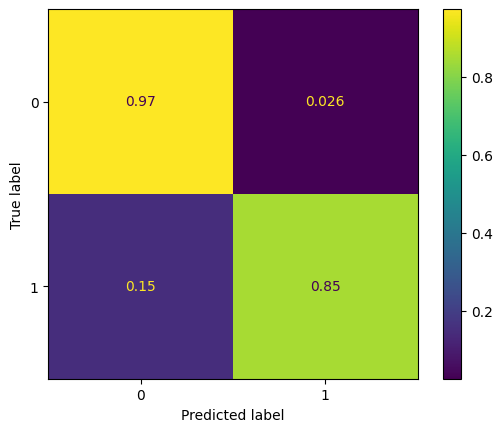

In [161]:
mods.plot_confusion_matrix(
    y_test, 
    ypred, 
    cutoff = np.sum(y_train[y_train == 1]) / len(y_train)
)

#### ROC Curve

2985/2985 [==============================] - 2s 549us/step


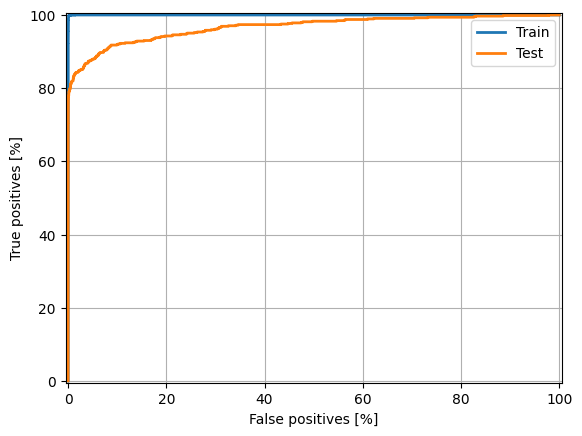

In [162]:
mods.plot_roc('Train', y_train, final_model.predict_proba(X_train)[:, 1])
mods.plot_roc('Test', y_test, ypred)
plt.legend()

#### ROC AUC

In [163]:
roc_auc_score(y_test, ypred)

0.9665521551800563

#### PR Curve

In [164]:
train_pr, train_re, _ = precision_recall_curve(y_train, final_model.predict_proba(X_train)[:, 1])
test_pr, test_re, _ = precision_recall_curve(y_test, ypred)

2985/2985 [==============================] - 2s 540us/step


In [165]:
def plot_pr(names, precisions, recalls):
    fig, ax = plt.subplots()
    
    for (name, precision, recall) in zip(names, precisions, recalls):
        ax.plot(100*precision, 100*recall, label = name)
    
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    
    ax.set_title('Precision-Recall Curve')
    ax.legend()
    
    plt.show()

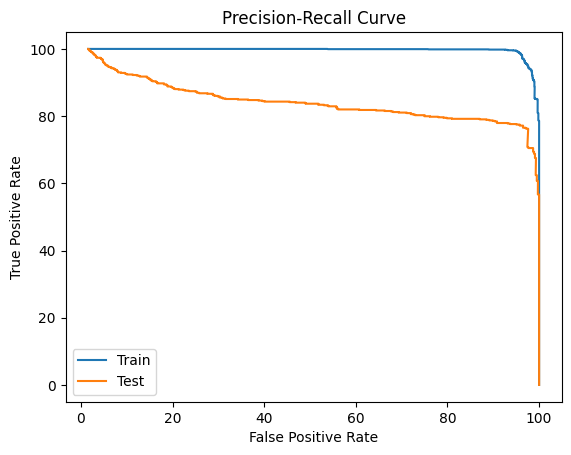

In [166]:
plot_pr(['Train', 'Test'], [train_pr, test_pr], [train_re, test_re])

#### PR AUC

In [167]:
average_precision_score(y_test, ypred)

0.8421452834064145

### Save Predictions <a id="savepreds"></a>

[Back to Model](#model)

In [168]:
test_data

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
0,136429,L50896,L,302.3,311.5,1499,38.0,60,0,0,0,0,0
1,136430,L53866,L,301.7,311.0,1713,28.8,17,0,0,0,0,0
2,136431,L50498,L,301.3,310.4,1525,37.7,96,0,0,0,0,0
3,136432,M21232,M,300.1,309.6,1479,47.6,5,0,0,0,0,0
4,136433,M19751,M,303.4,312.3,1515,41.3,114,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
90949,227378,L51130,L,302.3,311.4,1484,40.4,15,0,0,0,0,0
90950,227379,L47783,L,297.9,309.8,1542,33.8,31,0,0,0,0,0
90951,227380,L48097,L,295.6,306.2,1501,41.4,187,0,0,0,0,0
90952,227381,L48969,L,298.1,307.8,1534,40.3,69,0,0,0,0,0


In [169]:
X = test_data[numerical_features + categorical_features]

In [170]:
y = final_model.predict_proba(X)[:, 1]

2843/2843 [==============================] - 2s 522us/step


In [171]:
prediction = pd.DataFrame(
    {
        'id': test_data['id'],
        'Machine failure': y
    }
)

In [172]:
prediction.to_csv('predictions/prediction.csv', index = False)